<h1 style="text-align:center; color:#4682B4">SmartStock: Sentiment-Enhanced LSTM Predictions</h1>

## <span style="color:#4682B4">Project Objective</span>

This project explores the use of LSTM (Long Short-Term Memory) neural networks to predict AAPL, AMD, AMZN, INTC, META, MSFT, PYPL, and TSLA stock prices, integrating historical stock data with Google Trends data for enhanced predictive accuracy. LSTMs are particularly suited for time series forecasting due to their ability to capture long-term dependencies. By leveraging Google Trends, which provides insights into public interest and search volume for NVIDIA-related terms, the model can incorporate sentiment-driven features. The project demonstrates data preprocessing, feature engineering, and model training. This hybrid approach highlights how combining financial data with external indicators like Google Trends can improve stock price prediction accuracy.

## <span style="color:#4682B4">Business Benefits of Stock Price Prediction with LSTM and Google Trends</span>

1. **Enhanced Decision-Making**:
   - By accurately forecasting stock prices, businesses and investors can make informed decisions on buy/sell strategies, optimizing portfolio management and increasing returns.

2. **Incorporation of Public Sentiment**:
   - Using Google Trends data allows businesses to gauge market sentiment and its impact on stock movements, providing a competitive edge in understanding market dynamics.

3. **Risk Mitigation**:
   - Predictive insights help in identifying potential downturns or market volatility, enabling timely actions to minimize financial losses and manage risks effectively.

4. **Strategic Planning**:
   - Companies can align their strategies with predicted market trends, improving resource allocation and enhancing operational efficiency in trading and investment activities.

## <span style="color:#4682B4"> Import Libraries</span>

In [2515]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pytrends.request import TrendReq
import yfinance as yf
from datetime import datetime
from math import sqrt
import matplotlib.pyplot as plt
import pandas_ta as ta

In [2516]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

## <span style="color:#4682B4">Combined Dataset</span>

Combining the **sentiment**, **quantitative** ensures **google** across both datasets.

**Sentiment Dataset**

In [2517]:
df_sentiment = pd.read_csv('content/stock_tweets.csv')
# Define a function to display both head and tail of a DataFrame
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_sentiment.head(n), df_sentiment.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_sentiment, n=5)
# Display the result
result

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
80788  2021-10-07 17:11:57+00:00   
80789  2021-10-04 17:05:59+00:00   
80790  2021-10-01 04:43:41+00:00   
80791  2021-10-01 00:03:32+00:00   
80792  2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name  
0      Tesla, Inc.  
1      Tesla, Inc.  
2      Tesla, Inc.  
3      Tesla, Inc.  
4      Tesla, Inc.  
80788   XPeng Inc.  
80789   XPeng Inc.  
80790   XPeng Inc.  
80791   XPeng Inc.  
80792   XPeng Inc.

## <span style="color:#4682B4">Sentiment Analysis DATA is for (2022/09/29-2021/09/30)</span>

## <span style="color:#4682B4">Analyzing Tweet Sentiment with VADER Sentiment Analysis</span>

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a robust tool for sentiment analysis, particularly well-suited for social media text like tweets. It is a lexicon-based sentiment analysis tool designed to capture sentiment intensity, including context-aware aspects like negations, exclamations, and slang.

For this project, VADER is used to analyze tweet sentiment related to specific topics or stock performance. It categorizes sentiments as positive, negative, or neutral, assigning a compound score to indicate overall sentiment strength. This analysis helps uncover public opinion trends, which can be valuable for market sentiment evaluation or understanding user perceptions on social media.

In [2518]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Perform sentiment analysis
df_sentiment['scores'] = df_sentiment['Tweet'].apply(lambda text: analyzer.polarity_scores(text))
df_sentiment['compound'] = df_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date']).dt.date
# List of stocks to include
selected_stocks = ['AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'PYPL']
# Filter the dataset for the selected stocks
filtered_df = df_sentiment[df_sentiment['Stock Name'].isin(selected_stocks)]
# Ensure the Date column is properly formatted (strip time if present)
filtered_df['Date'] = pd.to_datetime(filtered_df['Date']).dt.date
# Group by Date and Stock Name, calculate the mean compound score
average_sentiment_by_date = (
    filtered_df.groupby(['Date', 'Stock Name'], as_index=False)['compound']
    .mean()
    .rename(columns={'compound': 'average_sentiment'})
)
# Verify no duplicates for the same stock and date
duplicates_check = average_sentiment_by_date.duplicated(subset=['Date', 'Stock Name']).sum()
print(f"Number of duplicate rows: {duplicates_check}")
# Display the result
print("Average sentiment scores by date for the selected stocks:")
print(average_sentiment_by_date)
# Example: Filter results for TSLA
stock_name = 'TSLA'
tsla_sentiment = average_sentiment_by_date[average_sentiment_by_date['Stock Name'] == stock_name]
print(f"\nAverage sentiment scores for {stock_name} by date:")
print(tsla_sentiment)


Number of duplicate rows: 0
Average sentiment scores by date for the selected stocks:
            Date Stock Name  average_sentiment
0     2021-09-30       AAPL           0.098900
1     2021-09-30        AMD           0.384217
2     2021-09-30       AMZN           0.256980
3     2021-09-30       META           0.472467
4     2021-09-30       MSFT           0.256980
...          ...        ...                ...
2552  2022-09-29       INTC          -0.827100
2553  2022-09-29       META          -0.051600
2554  2022-09-29       MSFT           0.086080
2555  2022-09-29       PYPL           0.630000
2556  2022-09-29       TSLA           0.057709

[2557 rows x 3 columns]

Average sentiment scores for TSLA by date:
            Date Stock Name  average_sentiment
5     2021-09-30       TSLA           0.251634
11    2021-10-01       TSLA           0.222412
17    2021-10-02       TSLA           0.307714
23    2021-10-03       TSLA           0.267680
30    2021-10-04       TSLA           0.151775

Display Sentiment data

In [2519]:
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_sentiment.head(n), df_sentiment.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_sentiment, n=5)
# Display the result
result

Date                                              Tweet  \
0      2022-09-29  Mainstream media has done an amazing job at br...   
1      2022-09-29  Tesla delivery estimates are at around 364k fr...   
2      2022-09-29  3/ Even if I include 63.0M unvested RSUs as of...   
3      2022-09-29  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...   
4      2022-09-29  @RealDanODowd @Tesla Stop trying to kill kids,...   
80788  2021-10-07  Some of the fastest growing tech stocks on the...   
80789  2021-10-04  With earnings on the horizon, here is a quick ...   
80790  2021-10-01  Our record delivery results are a testimony of...   
80791  2021-10-01  We delivered 10,412 Smart EVs in Sep 2021, rea...   
80792  2021-09-30  Why can XPeng P5 deliver outstanding performan...   

      Stock Name Company Name  \
0           TSLA  Tesla, Inc.   
1           TSLA  Tesla, Inc.   
2           TSLA  Tesla, Inc.   
3           TSLA  Tesla, Inc.   
4           TSLA  Tesla, Inc.   
80788       XPEV   XPeng Inc.   
80789       XPEV   XPeng Inc.   
80790       XPEV   XPeng Inc.   
80791       XPEV   XPeng Inc.   
80792       XPEV   XPeng Inc.   

                                                  scores  compound  
0      {'neg': 0.125, 'neu': 0.763, 'pos': 0.113, 'co...    0.0772  
1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
2      {'neg': 0.0, 'neu': 0.954, 'pos': 0.046, 'comp...    0.2960  
3      {'neg': 0.273, 'neu': 0.59, 'pos': 0.137, 'com...   -0.7568  
4      {'neg': 0.526, 'neu': 0.474, 'pos': 0.0, 'comp...   -0.8750  
80788  {'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...    0.1779  
80789  {'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'comp...    0.3818  
80790  {'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'comp...    0.4215  
80791  {'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'comp...    0.5423  
80792  {'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...    0.7783

In [2520]:
# Sort the DataFrame by Stock Name and then by Date
average_sentiment_by_date_sorted = average_sentiment_by_date.sort_values(by=['Stock Name', 'Date'])
# Save to CSV
output_file = "average_sentiment_by_date_sorted.csv"  # Update with your desired file path
average_sentiment_by_date_sorted.to_csv(output_file, index=False)
print(f"Output saved to: {output_file}")

Output saved to: average_sentiment_by_date_sorted.csv


In [2521]:
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([average_sentiment_by_date_sorted.head(n), average_sentiment_by_date_sorted.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(average_sentiment_by_date_sorted, n=5)
# Display the result
result

Date Stock Name  average_sentiment
0     2021-09-30       AAPL           0.098900
6     2021-10-01       AAPL           0.248255
12    2021-10-02       AAPL           0.007525
18    2021-10-03       AAPL           0.822500
24    2021-10-04       AAPL           0.122830
2529  2022-09-25       TSLA           0.150072
2535  2022-09-26       TSLA           0.114828
2541  2022-09-27       TSLA           0.225460
2548  2022-09-28       TSLA           0.129845
2556  2022-09-29       TSLA           0.057709

In [2522]:

df_sentiment_final = average_sentiment_by_date_sorted
df_sentiment_final.shape

(2557, 3)

## <span style="color:#4682B4">Stock Quantilative DATA is for (2022/09/29-2021/09/30)</span>

In [2523]:
import yfinance as yf
import pandas as pd
def download_stock_data(ticker, start_date="2021-09-30", end_date="2022-09-29"):
    """Download stock data for a given ticker from Yahoo Finance."""
    # Download stock price data, including actions (e.g., dividends)
    data = yf.download(ticker, start=start_date, end=end_date, actions=True)
    data.columns = data.columns.get_level_values(0)  # Flatten any multi-level column structure
    data['Ticker'] = ticker  # Add a column to identify the ticker
    return data
# List of selected stocks
selected_stocks = ['AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'PYPL']
# Initialize an empty DataFrame to store all data
df_stock_data = pd.DataFrame()
# Loop through each stock and append the data to the combined DataFrame
for stock in selected_stocks:
    stock_data = download_stock_data(stock)
    df_stock_data = pd.concat([df_stock_data, stock_data], axis=0)
# Reset the index of the combined DataFrame for consistency
df_stock_data.reset_index(inplace=True)
# Keep only the date part in the Date column
df_stock_data['Date'] = pd.to_datetime(df_stock_data['Date']).dt.date
# Display the first few rows of the combined DataFrame
df_stock_data.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price        Date   Adj Close       Close  Dividends        High         Low  \
0      2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1      2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2      2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   
3      2021-10-05  138.633453  141.110001        0.0  142.240005  139.360001   
4      2021-10-06  139.507812  142.000000        0.0  142.149994  138.369995   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2      141.759995           0.0  98322000   AAPL  
3      139.490005           0.0  80861100   AAPL  
4      139.470001           0.0  83221100   AAPL

In [2524]:
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_stock_data.head(n), df_stock_data.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_stock_data, n=5)
# Display the result
result

Price        Date   Adj Close       Close  Dividends        High         Low  \
0      2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1      2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2      2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   
3      2021-10-05  138.633453  141.110001        0.0  142.240005  139.360001   
4      2021-10-06  139.507812  142.000000        0.0  142.149994  138.369995   
2003   2022-09-22   87.660004   87.660004        0.0   91.500000   87.099998   
2004   2022-09-23   86.970001   86.970001        0.0   87.629997   85.680000   
2005   2022-09-26   84.260002   84.260002        0.0   89.080002   84.129997   
2006   2022-09-27   85.750000   85.750000        0.0   87.695000   84.580002   
2007   2022-09-28   91.120003   91.120003        0.0   91.650002   85.559998   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2      141.759995           0.0  98322000   AAPL  
3      139.490005           0.0  80861100   AAPL  
4      139.470001           0.0  83221100   AAPL  
2003    90.855003           0.0  12996900   PYPL  
2004    86.919998           0.0  12175900   PYPL  
2005    87.065002           0.0  16936400   PYPL  
2006    85.349998           0.0  11627600   PYPL  
2007    85.830002           0.0  14925900   PYPL

In [2525]:
df_stock_data_final = df_stock_data
df_stock_data_final.shape

(2008, 10)

## <span style="color:#4682B4">Google Trend DATA is for (2022/09/29-2021/09/30)</span>

In [2526]:
# import time
# import pandas as pd
# from pytrends.request import TrendReq

# def fetch_google_trends(keyword, timeframe="2021-09-30 2022-09-29"):
#     """Fetch Google Trends data for the specified keyword."""
#     pytrends = TrendReq(hl='en-US', tz=360)
#     pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='US', gprop='')
#     trends_data = pytrends.interest_over_time()
#     # Drop the 'isPartial' column if it exists
#     if 'isPartial' in trends_data.columns:
#         trends_data = trends_data.drop(columns=['isPartial'])
#     trends_data = trends_data.rename(columns={keyword: 'Google_Trends'})
#     trends_data['Ticker'] = keyword  # Add the Ticker column
#     return trends_data
# # List of selected keywords (stock tickers)
# keywords = ['AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'PYPL']
# # Initialize an empty DataFrame for combined data
# combined_trends_data = pd.DataFrame()
# # Loop through each keyword and append the data
# for keyword in keywords:
#     try:
#         keyword_data = fetch_google_trends(keyword)
#         combined_trends_data = pd.concat([combined_trends_data, keyword_data], axis=0)
#     except Exception as e:
#         print(f"Failed to fetch data for {keyword}: {e}")
# # Reset the index and ensure 'Date' is a column
# combined_trends_data.reset_index(inplace=True)
# combined_trends_data.rename(columns={'date': 'Date'}, inplace=True)
# # Save to CSV
# combined_trends_data.to_csv('google_trends_data.csv', index=False)
# # Display the first few rows of the combined DataFrame
# print(combined_trends_data.head())

In [2527]:
df_google_trend = pd.read_csv('content/google_trends_data.csv')
# Define a function to display both head and tail of a DataFrame
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_google_trend.head(n), df_google_trend.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_google_trend, n=5)
# Display the result
result

Date  Google_Trends Ticker
0    2021-09-26             51   AAPL
1    2021-10-03             54   AAPL
2    2021-10-10             48   AAPL
3    2021-10-17             55   AAPL
4    2021-10-24             77   AAPL
419  2022-08-28             11   PYPL
420  2022-09-04              9   PYPL
421  2022-09-11             12   PYPL
422  2022-09-18             11   PYPL
423  2022-09-25             10   PYPL

In [2528]:
import pandas as pd
# Load the Google Trends data
df_google_trend = pd.read_csv('content/google_trends_data.csv')
# Convert 'Date' column to datetime format
df_google_trend['Date'] = pd.to_datetime(df_google_trend['Date'])
# Define the complete date range
start_date = "2021-09-30"
end_date = "2022-09-29"
all_dates = pd.date_range(start=start_date, end=end_date)
# Create a DataFrame with all dates for each Ticker
tickers = df_google_trend['Ticker'].unique()
complete_data = pd.DataFrame()
for ticker in tickers:
    # Filter data for the current Ticker
    ticker_data = df_google_trend[df_google_trend['Ticker'] == ticker]
    # Reindex with all dates
    ticker_data = ticker_data.set_index('Date')
    ticker_data = ticker_data.reindex(all_dates, fill_value=0)
    # Reset index and add Ticker column
    ticker_data = ticker_data.reset_index()
    ticker_data.rename(columns={'index': 'Date'}, inplace=True)
    ticker_data['Ticker'] = ticker
    # Append to the complete DataFrame
    complete_data = pd.concat([complete_data, ticker_data])
# Save the complete DataFrame
complete_data.to_csv('content/complete_google_trends_data.csv', index=False)
# Display the first few rows of the complete data
complete_data.head()

Date  Google_Trends Ticker
0 2021-09-30              0   AAPL
1 2021-10-01              0   AAPL
2 2021-10-02              0   AAPL
3 2021-10-03             54   AAPL
4 2021-10-04              0   AAPL

In [2529]:
df_google_trend_complete = pd.read_csv('content/complete_google_trends_data.csv')
# Define a function to display both head and tail of a DataFrame
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_google_trend_complete.head(n), df_google_trend_complete.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_google_trend_complete, n=5)
# Display the result
result

Date  Google_Trends Ticker
0     2021-09-30              0   AAPL
1     2021-10-01              0   AAPL
2     2021-10-02              0   AAPL
3     2021-10-03             54   AAPL
4     2021-10-04              0   AAPL
2915  2022-09-25             10   PYPL
2916  2022-09-26              0   PYPL
2917  2022-09-27              0   PYPL
2918  2022-09-28              0   PYPL
2919  2022-09-29              0   PYPL

In [2530]:
df_google_trend_final = df_google_trend_complete
df_google_trend_final.shape

(2920, 3)

Now we have 3 different datasets - lets merge all 3

In [2531]:
print(df_google_trend_final.shape)
print(df_sentiment_final.shape)
print(df_stock_data_final.shape)

(2920, 3)
(2557, 3)
(2008, 10)


In [2532]:
# Rename the column "Stock Name" to "Ticker"
df_sentiment_final.rename(columns={"Stock Name": "Ticker"}, inplace=True)

# Display the updated DataFrame
print(df_sentiment_final.head())

          Date Ticker  average_sentiment
0   2021-09-30   AAPL           0.098900
6   2021-10-01   AAPL           0.248255
12  2021-10-02   AAPL           0.007525
18  2021-10-03   AAPL           0.822500
24  2021-10-04   AAPL           0.122830


In [2533]:

# Convert 'Date' column to datetime format
df_stock_data_final['Date'] = pd.to_datetime(df_stock_data_final['Date'])

# Define the complete date range
start_date = "2021-09-30"
end_date = "2022-09-29"
all_dates = pd.date_range(start=start_date, end=end_date)
# Create a DataFrame with all dates for each Ticker
tickers = df_sentiment_final['Ticker'].unique()
complete_data = pd.DataFrame()
for ticker in tickers:
    # Filter data for the current Ticker
    ticker_data = df_stock_data_final[df_stock_data_final['Ticker'] == ticker]
    
    # Reindex with all dates
    ticker_data = ticker_data.set_index('Date')
    ticker_data = ticker_data.reindex(all_dates, fill_value=0)
    
    # Reset index and add Ticker column
    ticker_data = ticker_data.reset_index()
    ticker_data.rename(columns={'index': 'Date'}, inplace=True)
    ticker_data['Ticker'] = ticker
    
    # Append to the complete DataFrame
    complete_data = pd.concat([complete_data, ticker_data])
df_stock_data_final_adjusted = complete_data

# Display the first few rows of the complete data
df_stock_data_final_adjusted.head()

Price       Date   Adj Close       Close  Dividends        High         Low  \
0     2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1     2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2     2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3     2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4     2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2        0.000000           0.0         0   AAPL  
3        0.000000           0.0         0   AAPL  
4      141.759995           0.0  98322000   AAPL

In [2534]:
# Save the DataFrame to a CSV file
df_stock_data_final_adjusted.to_csv('df_stock_data_final_adjusted.csv', index=False)

print("DataFrame has been saved to 'df_stock_data_final_adjusted.csv'.")

DataFrame has been saved to 'df_stock_data_final_adjusted.csv'.


In [2535]:
df_stock_data_final_adjusted.shape

(2920, 10)

In [2536]:

# Convert 'Date' column to datetime format
df_sentiment_final['Date'] = pd.to_datetime(df_sentiment_final['Date'])

# Define the complete date range
start_date = "2021-09-30"
end_date = "2022-09-29"
all_dates = pd.date_range(start=start_date, end=end_date)
# Create a DataFrame with all dates for each Ticker
tickers = df_sentiment_final['Ticker'].unique()
complete_data = pd.DataFrame()
for ticker in tickers:
    # Filter data for the current Ticker
    ticker_data = df_sentiment_final[df_sentiment_final['Ticker'] == ticker]
    
    # Reindex with all dates
    ticker_data = ticker_data.set_index('Date')
    ticker_data = ticker_data.reindex(all_dates, fill_value=0)
    
    # Reset index and add Ticker column
    ticker_data = ticker_data.reset_index()
    ticker_data.rename(columns={'index': 'Date'}, inplace=True)
    ticker_data['Ticker'] = ticker
    
    # Append to the complete DataFrame
    complete_data = pd.concat([complete_data, ticker_data])
df_sentiment_final_adjusted = complete_data

# Display the first few rows of the complete data
df_sentiment_final_adjusted.head()

Date Ticker  average_sentiment
0 2021-09-30   AAPL           0.098900
1 2021-10-01   AAPL           0.248255
2 2021-10-02   AAPL           0.007525
3 2021-10-03   AAPL           0.822500
4 2021-10-04   AAPL           0.122830

In [2537]:
print(df_google_trend_final.shape)
print(df_sentiment_final_adjusted.shape)
print(df_stock_data_final_adjusted.shape)

(2920, 3)
(2920, 3)
(2920, 10)


In [2538]:
df_google_trend_final.head()

Date  Google_Trends Ticker
0  2021-09-30              0   AAPL
1  2021-10-01              0   AAPL
2  2021-10-02              0   AAPL
3  2021-10-03             54   AAPL
4  2021-10-04              0   AAPL

In [2539]:
df_sentiment_final_adjusted.head()

Date Ticker  average_sentiment
0 2021-09-30   AAPL           0.098900
1 2021-10-01   AAPL           0.248255
2 2021-10-02   AAPL           0.007525
3 2021-10-03   AAPL           0.822500
4 2021-10-04   AAPL           0.122830

In [2540]:
df_stock_data_final_adjusted.head()

Price       Date   Adj Close       Close  Dividends        High         Low  \
0     2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1     2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2     2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3     2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4     2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2        0.000000           0.0         0   AAPL  
3        0.000000           0.0         0   AAPL  
4      141.759995           0.0  98322000   AAPL

In [2541]:
import pandas as pd
# Ensure the DataFrames are loaded into your environment
# Example: df_stock_data_final_adjusted = pd.read_csv('df_stock_data_final_adjusted.csv')
# Example: df_google_trend_final = pd.read_csv('df_google_trend_final.csv')
# Convert 'Date' columns to datetime format for consistency
df_stock_data_final_adjusted['Date'] = pd.to_datetime(df_stock_data_final_adjusted['Date'])
df_google_trend_final['Date'] = pd.to_datetime(df_google_trend_final['Date'])
# Merge the 'Google_Trends' column from df_google_trend_final into df_stock_data_final_adjusted
df_stock_data_final_adjusted = pd.merge(
    df_stock_data_final_adjusted,
    df_google_trend_final[['Date', 'Ticker', 'Google_Trends']],
    on=['Date', 'Ticker'],
    how='left'
)


In [2542]:
# Display the first few rows of the updated DataFrame
df_stock_data_final_adjusted.tail()


Date   Adj Close       Close  Dividends        High         Low  \
2915 2022-09-25    0.000000    0.000000        0.0    0.000000    0.000000   
2916 2022-09-26  276.010010  276.010010        0.0  284.089996  270.309998   
2917 2022-09-27  282.940002  282.940002        0.0  288.670013  277.510010   
2918 2022-09-28  287.809998  287.809998        0.0  289.000000  277.570007   
2919 2022-09-29    0.000000    0.000000        0.0    0.000000    0.000000   

            Open  Stock Splits    Volume Ticker  Google_Trends  
2915    0.000000           0.0         0   TSLA             38  
2916  271.829987           0.0  58076900   TSLA              0  
2917  283.839996           0.0  61925200   TSLA              0  
2918  283.079987           0.0  54664800   TSLA              0  
2919    0.000000           0.0         0   TSLA              0

In [2543]:
import pandas as pd
# Ensure the DataFrames are loaded into your environment
# Example: df_stock_data_final_adjusted = pd.read_csv('df_stock_data_final_adjusted.csv')
# Example: df_google_trend_final = pd.read_csv('df_google_trend_final.csv')
# Convert 'Date' columns to datetime format for consistency
df_stock_data_final_adjusted['Date'] = pd.to_datetime(df_stock_data_final_adjusted['Date'])
df_sentiment_final_adjusted['Date'] = pd.to_datetime(df_sentiment_final_adjusted['Date'])
# Merge the 'Google_Trends' column from df_google_trend_final into df_stock_data_final_adjusted
df_stock_data_final_adjusted = pd.merge(
    df_stock_data_final_adjusted,
    df_sentiment_final_adjusted[['Date', 'Ticker', 'average_sentiment']],
    on=['Date', 'Ticker'],
    how='left'
)

In [2544]:
# Display the first few rows of the updated DataFrame
df_stock_data_final_adjusted.head()

Date   Adj Close       Close  Dividends        High         Low  \
0 2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1 2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2 2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3 2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4 2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

         Open  Stock Splits    Volume Ticker  Google_Trends  average_sentiment  
0  143.660004           0.0  89056700   AAPL              0           0.098900  
1  141.899994           0.0  94639600   AAPL              0           0.248255  
2    0.000000           0.0         0   AAPL              0           0.007525  
3    0.000000           0.0         0   AAPL             54           0.822500  
4  141.759995           0.0  98322000   AAPL              0           0.122830

In [2545]:
# Drop rows where both 'Close' and 'Open' columns are 0.000000
df_stock_data_final_adjusted = df_stock_data_final_adjusted[
    ~((df_stock_data_final_adjusted['Close'] == 0.000000) & 
      (df_stock_data_final_adjusted['Open'] == 0.000000))
]

In [2546]:
def calculate_technical_indicators(data):
#Overlap Studies
    # Daily return
 data['daily_return'] = data['Close'].pct_change()
 data['ma'] = ta.ma(data['Close'],timeperiod=10)
 data['ema'] = ta.ema(data['Close'],timeperiod=10)
 data['dema'] = ta.dema(data['Close'],timeperiod=10)
 data['kamaw'] = ta.kama(data['Close'],timeperiod=10)
 data['ma'] = ta.wma(data['Close'],timeperiod=10)
 data['midprice'] = ta.midprice(data['High'], data['Low'],timeperiod=10)

#Momentum Indicator
 adx = ta.adx(data['High'], data['Low'], data['Close'])
 data = pd.concat([data, adx], axis=1)
 data['bop'] = ta.bop(data['Open'], data['High'], data['Low'], data['Close'])
 data['cmo'] = ta.cmo(data['Close'],timeperiod=10)
 data['mfi'] = ta.mfi(data['High'], data['Low'], data['Close'], data['Volume'])
 data['RrocOC'] = ta.roc(data['Close'],timeperiod=10)
 data['willr'] = ta.willr(data['High'], data['Low'], data['Close'], timeperiod=14)

#Volume
 data['ad'] = ta.ad(data['High'], data['Low'], data['Close'], data['Volume'])
 data['obv'] = ta.obv(data['Close'], data['Volume'])

#Volatility
 data['natr'] = ta.natr(data['High'], data['Low'], data['Close'], timeperiod=14)
 data['atr'] = ta.atr(data['High'], data['Low'], data['Close'], timeperiod=14)
 data['true_range'] = ta.true_range(data['High'], data['Low'], data['Close'])

 data['rsi'] = ta.rsi(data['Close'])
# Moving Average Volatility (Standard Deviation of Returns)
# Interaction feature: Volume * Price Change
 data['volume_price_interaction'] = data['Volume'] * data['daily_return']
#MISC
 tsi = ta.tsi(data['Close'], timeperiod=14)
 data = pd.concat([data, tsi], axis=1)
# Replace inf values with NaN
 data.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
 return data



In [2547]:
# Display the first few rows of the updated DataFrame
df_stock_data_final_adjusted = calculate_technical_indicators(df_stock_data_final_adjusted)


In [2548]:
df_stock_data_final_adjusted.columns

Index(['Date', 'Adj Close', 'Close', 'Dividends', 'High', 'Low', 'Open',
       'Stock Splits', 'Volume', 'Ticker', 'Google_Trends',
       'average_sentiment', 'daily_return', 'ma', 'ema', 'dema', 'kamaw',
       'midprice', 'ADX_14', 'DMP_14', 'DMN_14', 'bop', 'cmo', 'mfi', 'RrocOC',
       'willr', 'ad', 'obv', 'natr', 'atr', 'true_range', 'rsi',
       'volume_price_interaction', 'TSI_13_25_13', 'TSIs_13_25_13'],
      dtype='object')

In [2549]:
# Move 'daily_return' to the second column
cols = list(df_stock_data_final_adjusted.columns)  # Get all column names
cols.insert(1, cols.pop(cols.index("daily_return")))  # Move 'daily_return' to second position
df_stock_data_final_adjusted = df_stock_data_final_adjusted[cols]  # Reorder the columns


In [2550]:
# Define a function to display both head and tail of a DataFrame
def display_head_tail(data, n=10):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_stock_data_final_adjusted.head(n), df_stock_data_final_adjusted.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_stock_data_final_adjusted, n=5)
# Display the result
result

Date  daily_return   Adj Close       Close  Dividends        High  \
0    2021-09-30           NaN  139.016602  141.500000        0.0  144.380005   
1    2021-10-01      0.008127  140.146408  142.649994        0.0  142.919998   
4    2021-10-04     -0.024606  136.697983  139.139999        0.0  142.210007   
5    2021-10-05      0.014158  138.633453  141.110001        0.0  142.240005   
6    2021-10-06      0.006307  139.507812  142.000000        0.0  142.149994   
2912 2022-09-22     -0.040592  288.589996  288.589996        0.0  301.290009   
2913 2022-09-23     -0.045948  275.329987  275.329987        0.0  284.500000   
2916 2022-09-26      0.002470  276.010010  276.010010        0.0  284.089996   
2917 2022-09-27      0.025108  282.940002  282.940002        0.0  288.670013   
2918 2022-09-28      0.017212  287.809998  287.809998        0.0  289.000000   

             Low        Open  Stock Splits    Volume  ...      willr  \
0     141.279999  143.660004           0.0  89056700  ...        NaN   
1     139.110001  141.899994           0.0  94639600  ...        NaN   
4     138.270004  141.759995           0.0  98322000  ...        NaN   
5     139.360001  139.490005           0.0  80861100  ...        NaN   
6     138.369995  139.470001           0.0  83221100  ...        NaN   
2912  285.820007  299.859985           0.0  70545400  ... -52.455249   
2913  272.820007  283.089996           0.0  63748400  ... -80.045783   
2916  270.309998  271.829987           0.0  58076900  ... -86.893508   
2917  277.510010  283.839996           0.0  61925200  ... -70.958823   
2918  277.570007  283.079987           0.0  54664800  ... -59.760856   

                ad           obv      natr        atr  true_range        rsi  \
0    -7.641635e+07  8.905670e+07       NaN        NaN         NaN        NaN   
1     4.809544e+06  1.836963e+08       NaN        NaN    3.809998        NaN   
4    -5.009134e+07  8.537430e+07       NaN        NaN    4.379990        NaN   
5    -3.268390e+07  1.662354e+08       NaN        NaN    3.100006        NaN   
6     4.393261e+07  2.494565e+08       NaN        NaN    3.779999        NaN   
2912  1.841987e+09 -2.769664e+09  3.942381  11.429797   15.470001  47.344838   
2913  1.805638e+09 -2.833412e+09  4.344971  11.739811   15.769989  40.570790   
2916  1.795607e+09 -2.775335e+09  4.422040  11.885539   13.779999  41.036721   
2917  1.793942e+09 -2.713410e+09  4.335161  11.940857   12.660004  45.708155   
2918  1.837224e+09 -2.658745e+09  4.223081  11.904367   11.429993  48.779262   

      volume_price_interaction  TSI_13_25_13  TSIs_13_25_13  
0                          NaN           NaN            NaN  
1                 7.691517e+05           NaN            NaN  
4                -2.419276e+06           NaN            NaN  
5                 1.144865e+06           NaN            NaN  
6                 5.248865e+05           NaN            NaN  
2912             -2.863560e+06     10.615392      10.102977  
2913             -2.929084e+06      5.635267       9.464732  
2916              1.434411e+05      1.894329       8.383246  
2917              1.554803e+06      0.187943       7.212489  
2918              9.408967e+05     -0.276991       6.142563  

[10 rows x 35 columns]

In [2551]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Apply Label Encoding to the 'Ticker' column
df_stock_data_final_adjusted['Ticker_Label'] = label_encoder.fit_transform(df_stock_data_final_adjusted['Ticker'])
# Display the first few rows to verify the changes
print(df_stock_data_final_adjusted[['Ticker', 'Ticker_Label']].head())
# If you need to map labels back to the original tickers:
ticker_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Ticker to Label Mapping:", ticker_mapping)

  Ticker  Ticker_Label
0   AAPL             0
1   AAPL             0
4   AAPL             0
5   AAPL             0
6   AAPL             0
Ticker to Label Mapping: {'AAPL': 0, 'AMD': 1, 'AMZN': 2, 'INTC': 3, 'META': 4, 'MSFT': 5, 'PYPL': 6, 'TSLA': 7}


In [2552]:
df_stock_data_final_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2008 entries, 0 to 2918
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      2008 non-null   datetime64[ns]
 1   daily_return              2007 non-null   float64       
 2   Adj Close                 2008 non-null   float64       
 3   Close                     2008 non-null   float64       
 4   Dividends                 2008 non-null   float64       
 5   High                      2008 non-null   float64       
 6   Low                       2008 non-null   float64       
 7   Open                      2008 non-null   float64       
 8   Stock Splits              2008 non-null   float64       
 9   Volume                    2008 non-null   int64         
 10  Ticker                    2008 non-null   object        
 11  Google_Trends             2008 non-null   int64         
 12  average_sentiment        

In [2553]:
# Remove duplicate columns from the DataFrame
df_stock_data_final_adjusted = df_stock_data_final_adjusted.loc[:, ~df_stock_data_final_adjusted.columns.duplicated()]
# Display the updated DataFrame
df_stock_data_final_adjusted.columns

Index(['Date', 'daily_return', 'Adj Close', 'Close', 'Dividends', 'High',
       'Low', 'Open', 'Stock Splits', 'Volume', 'Ticker', 'Google_Trends',
       'average_sentiment', 'ma', 'ema', 'dema', 'kamaw', 'midprice', 'ADX_14',
       'DMP_14', 'DMN_14', 'bop', 'cmo', 'mfi', 'RrocOC', 'willr', 'ad', 'obv',
       'natr', 'atr', 'true_range', 'rsi', 'volume_price_interaction',
       'TSI_13_25_13', 'TSIs_13_25_13', 'Ticker_Label'],
      dtype='object')

In [2554]:
df_stock_data_final_adjusted.isna().sum()

Date                         0
daily_return                 1
Adj Close                    0
Close                        0
Dividends                    0
High                         0
Low                          0
Open                         0
Stock Splits                 0
Volume                       0
Ticker                       0
Google_Trends                0
average_sentiment            0
ma                           9
ema                          9
dema                         9
kamaw                        9
midprice                     1
ADX_14                      27
DMP_14                      14
DMN_14                      14
bop                          0
cmo                         14
mfi                         13
RrocOC                      10
willr                       13
ad                           0
obv                          0
natr                        13
atr                         14
true_range                   1
rsi                         14
volume_p

In [2555]:
import pandas as pd
from sklearn.impute import KNNImputer
# Drop non-numeric columns
df_stock_data_final_imp = df_stock_data_final_adjusted
# Define columns to apply imputation
columns_to_impute = ['daily_return', 'ma', 'ema', 'dema', 
                     'kamaw', 'midprice', 'ADX_14', 'DMP_14', 'DMN_14', 
                     'cmo', 'mfi', 'RrocOC', 'willr', 'natr', 'atr', 
                     'true_range', 'rsi', 'volume_price_interaction', 
                     'TSI_13_25_13', 'TSIs_13_25_13']
# Drop 'Volatility' column if it is constant or irrelevant
columns_to_impute = [col for col in columns_to_impute if df_stock_data_final_imp[col].nunique() > 1]
# Select columns for imputation
df_to_impute = df_stock_data_final_imp[columns_to_impute]
# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_to_impute)
# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed_array, columns=columns_to_impute, index=df_to_impute.index)
# Combine imputed data with the original DataFrame
df_stock_data_final_imp.update(df_imputed)
# Display the updated DataFrame
df_stock_data_final_imp.head()

Date  daily_return   Adj Close       Close  Dividends        High  \
0 2021-09-30      0.006278  139.016602  141.500000        0.0  144.380005   
1 2021-10-01      0.008127  140.146408  142.649994        0.0  142.919998   
4 2021-10-04     -0.024606  136.697983  139.139999        0.0  142.210007   
5 2021-10-05      0.014158  138.633453  141.110001        0.0  142.240005   
6 2021-10-06      0.006307  139.507812  142.000000        0.0  142.149994   

          Low        Open  Stock Splits    Volume  ...            ad  \
0  141.279999  143.660004           0.0  89056700  ... -7.641635e+07   
1  139.110001  141.899994           0.0  94639600  ...  4.809544e+06   
4  138.270004  141.759995           0.0  98322000  ... -5.009134e+07   
5  139.360001  139.490005           0.0  80861100  ... -3.268390e+07   
6  138.369995  139.470001           0.0  83221100  ...  4.393261e+07   

           obv      natr        atr  true_range        rsi  \
0   89056700.0  4.170424   7.301378    7.331775  48.492967   
1  183696300.0  4.659334  10.727475    3.809998  61.266797   
4   85374300.0  4.731580   6.466940    4.379990  39.787884   
5  166235400.0  3.130105   7.960814    3.100006  61.306032   
6  249456500.0  4.308849  10.853074    3.779999  47.983564   

   volume_price_interaction  TSI_13_25_13  TSIs_13_25_13  Ticker_Label  
0              1.088321e+05     -2.556374      -2.479374             0  
1              7.691517e+05     14.416719      10.406948             0  
4             -2.419276e+06     -8.988521      -7.495520             0  
5              1.144865e+06     15.354422       8.966424             0  
6              5.248865e+05    -14.727058     -14.508166             0  

[5 rows x 36 columns]

In [2556]:
df_stock_data_final_imp.isna().sum()

Date                        0
daily_return                0
Adj Close                   0
Close                       0
Dividends                   0
High                        0
Low                         0
Open                        0
Stock Splits                0
Volume                      0
Ticker                      0
Google_Trends               0
average_sentiment           0
ma                          0
ema                         0
dema                        0
kamaw                       0
midprice                    0
ADX_14                      0
DMP_14                      0
DMN_14                      0
bop                         0
cmo                         0
mfi                         0
RrocOC                      0
willr                       0
ad                          0
obv                         0
natr                        0
atr                         0
true_range                  0
rsi                         0
volume_price_interaction    0
TSI_13_25_

In [2557]:
# Convert all column names to lowercase
df_stock_data_final_imp.columns = df_stock_data_final_imp.columns.str.lower()
# Display the updated column names
print(df_stock_data_final_imp.columns)

Index(['date', 'daily_return', 'adj close', 'close', 'dividends', 'high',
       'low', 'open', 'stock splits', 'volume', 'ticker', 'google_trends',
       'average_sentiment', 'ma', 'ema', 'dema', 'kamaw', 'midprice', 'adx_14',
       'dmp_14', 'dmn_14', 'bop', 'cmo', 'mfi', 'rrococ', 'willr', 'ad', 'obv',
       'natr', 'atr', 'true_range', 'rsi', 'volume_price_interaction',
       'tsi_13_25_13', 'tsis_13_25_13', 'ticker_label'],
      dtype='object')


In [2558]:
df_stock_data_final_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2008 entries, 0 to 2918
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      2008 non-null   datetime64[ns]
 1   daily_return              2008 non-null   float64       
 2   adj close                 2008 non-null   float64       
 3   close                     2008 non-null   float64       
 4   dividends                 2008 non-null   float64       
 5   high                      2008 non-null   float64       
 6   low                       2008 non-null   float64       
 7   open                      2008 non-null   float64       
 8   stock splits              2008 non-null   float64       
 9   volume                    2008 non-null   int64         
 10  ticker                    2008 non-null   object        
 11  google_trends             2008 non-null   int64         
 12  average_sentiment        

<h2 style="color:#4682B4">Basic Data Exploration</h2>

## <span style="color:#4682B4">Check Distribution Pattern for Independent Variables</span>

Analyzing the distribution pattern of independent variables is crucial for understanding the underlying data structure. It helps identify trends, outliers, and any potential skewness in the variables. By visualizing the distributions, we can determine whether any transformations or adjustments are needed to make the data more suitable for model training.

Examining the distribution of each variable provides insights into whether the data is normally distributed, if there are any extreme values (outliers), or if the data is skewed in any direction. This information is essential for making decisions on data transformations and improving model performance.

By understanding the distribution patterns, we can ensure that the dataset is well-prepared for model training, leading to better accuracy and robustness in predictions.

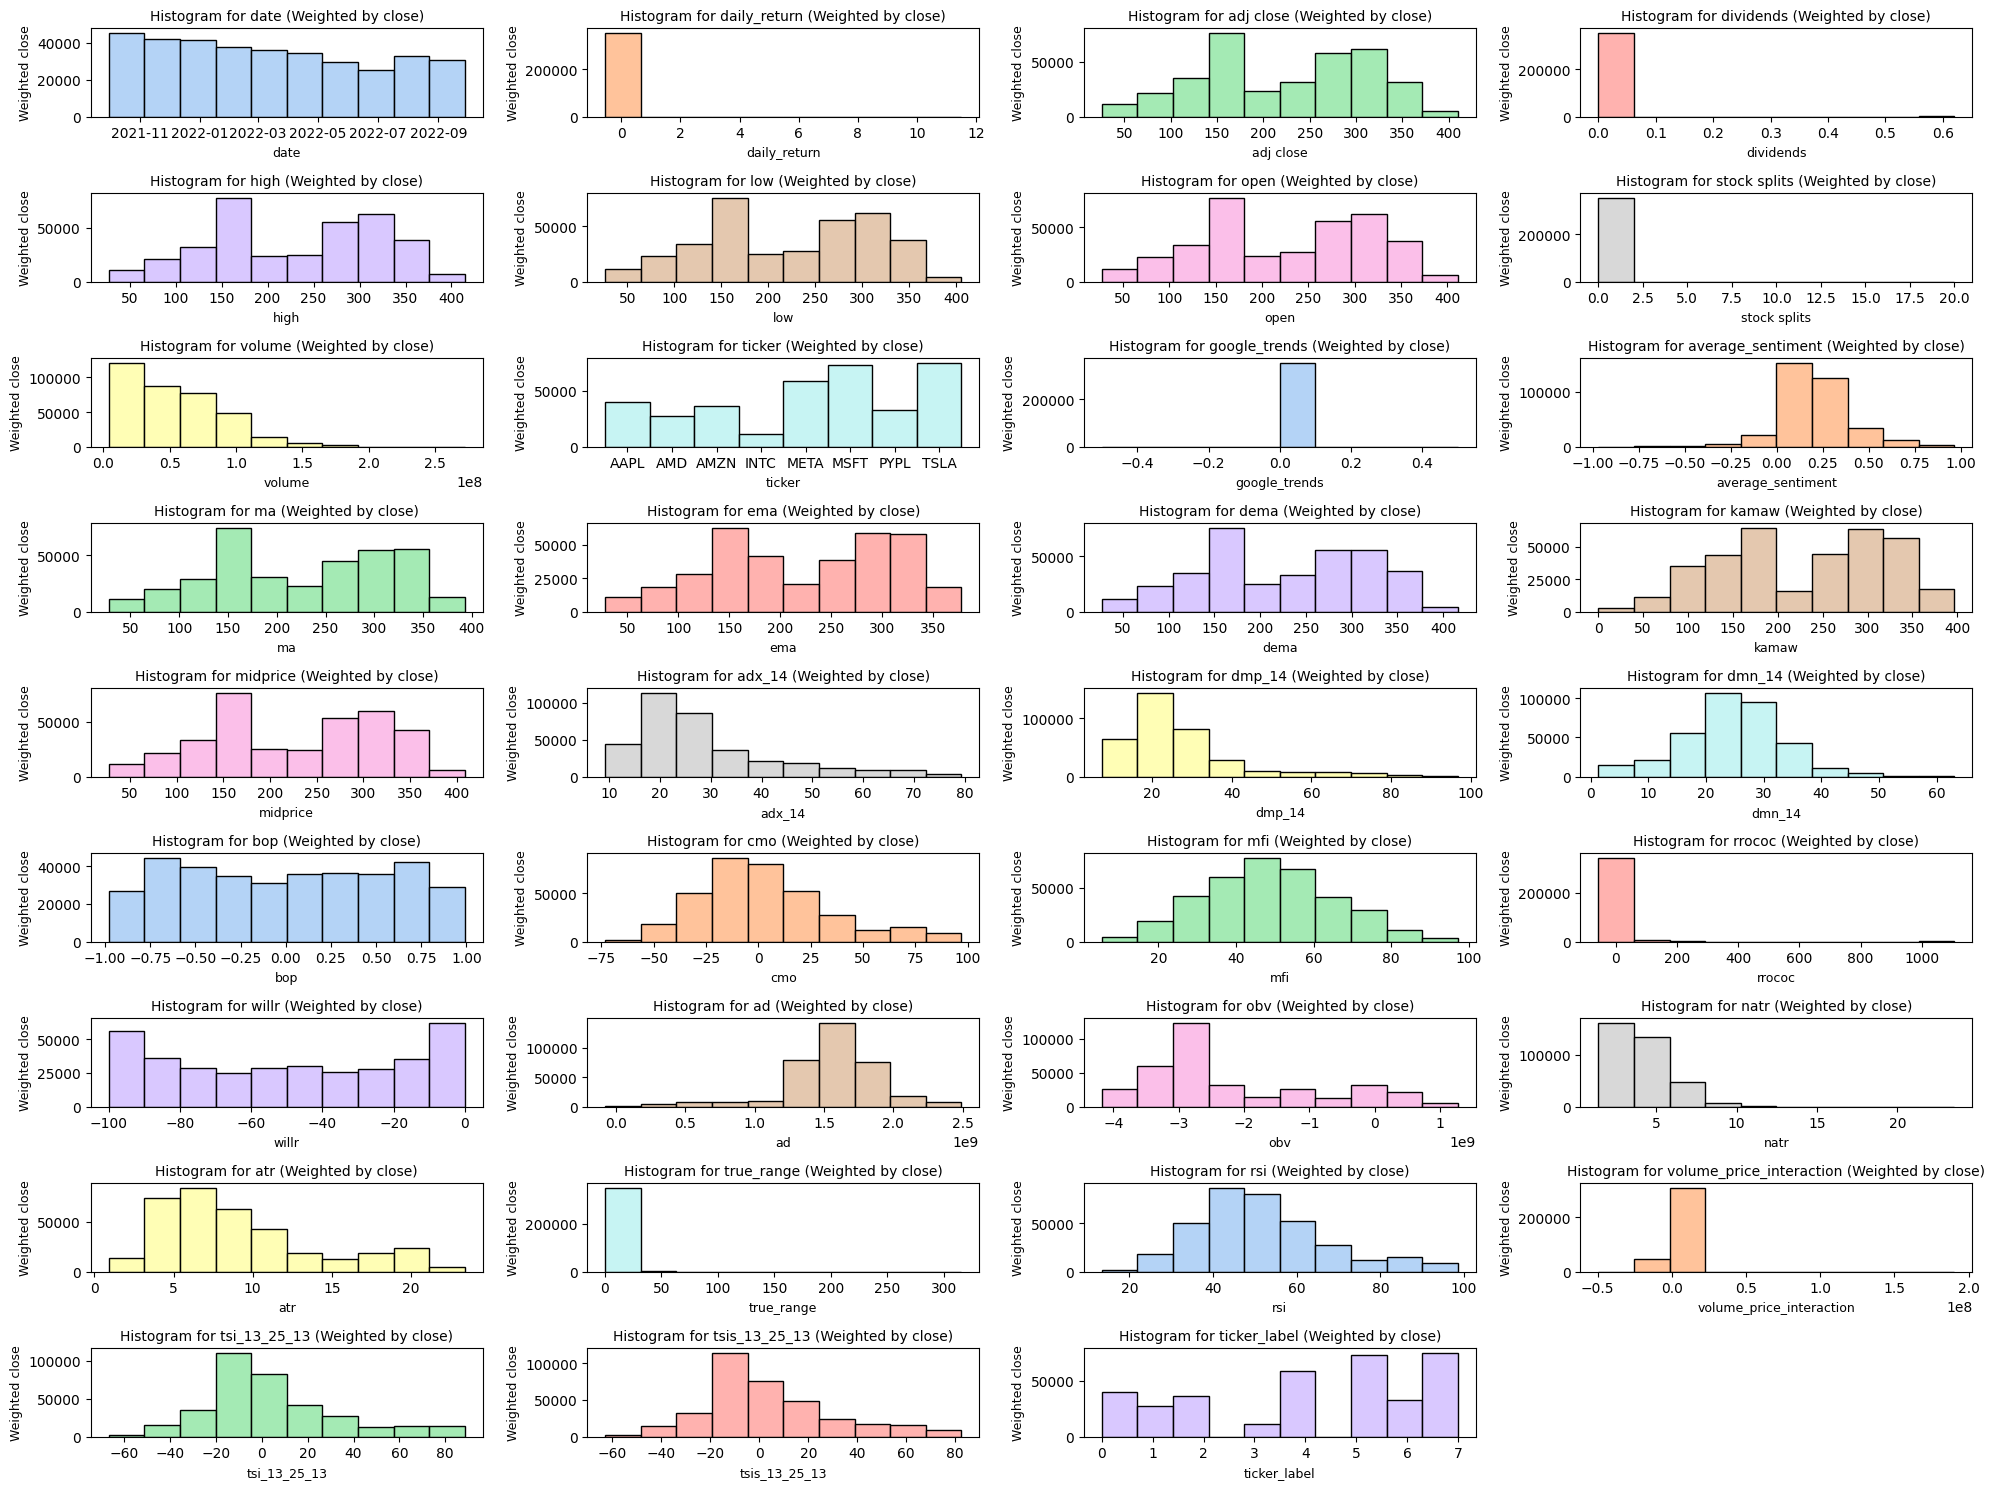

In [2584]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features
features = df_stock_data_final_imp.columns.tolist()
target = 'close'

# Remove the target from the feature list
features.remove(target)

# Use Seaborn's pastel palette
colors = sns.color_palette("pastel", 10)

# Set up the number of rows and columns for subplots
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols  # Calculate rows required for given columns

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes array for easier access
# Plot each feature in a subplot
for i, feature in enumerate(features):
    sns.histplot(
        x=df_stock_data_final_imp[feature],
        weights=df_stock_data_final_imp[target],
        ax=axes[i],
        bins=10,
        color=colors[i % len(colors)],  # Cycle through the pastel colors
        alpha=0.8
    )
    axes[i].set_title(f"Histogram for {feature} (Weighted by {target})", fontsize=10)
    axes[i].set_xlabel(feature, fontsize=9)
    axes[i].set_ylabel(f"Weighted {target}", fontsize=9)
# Remove any empty subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])
# Adjust the layout
plt.tight_layout()
plt.show()

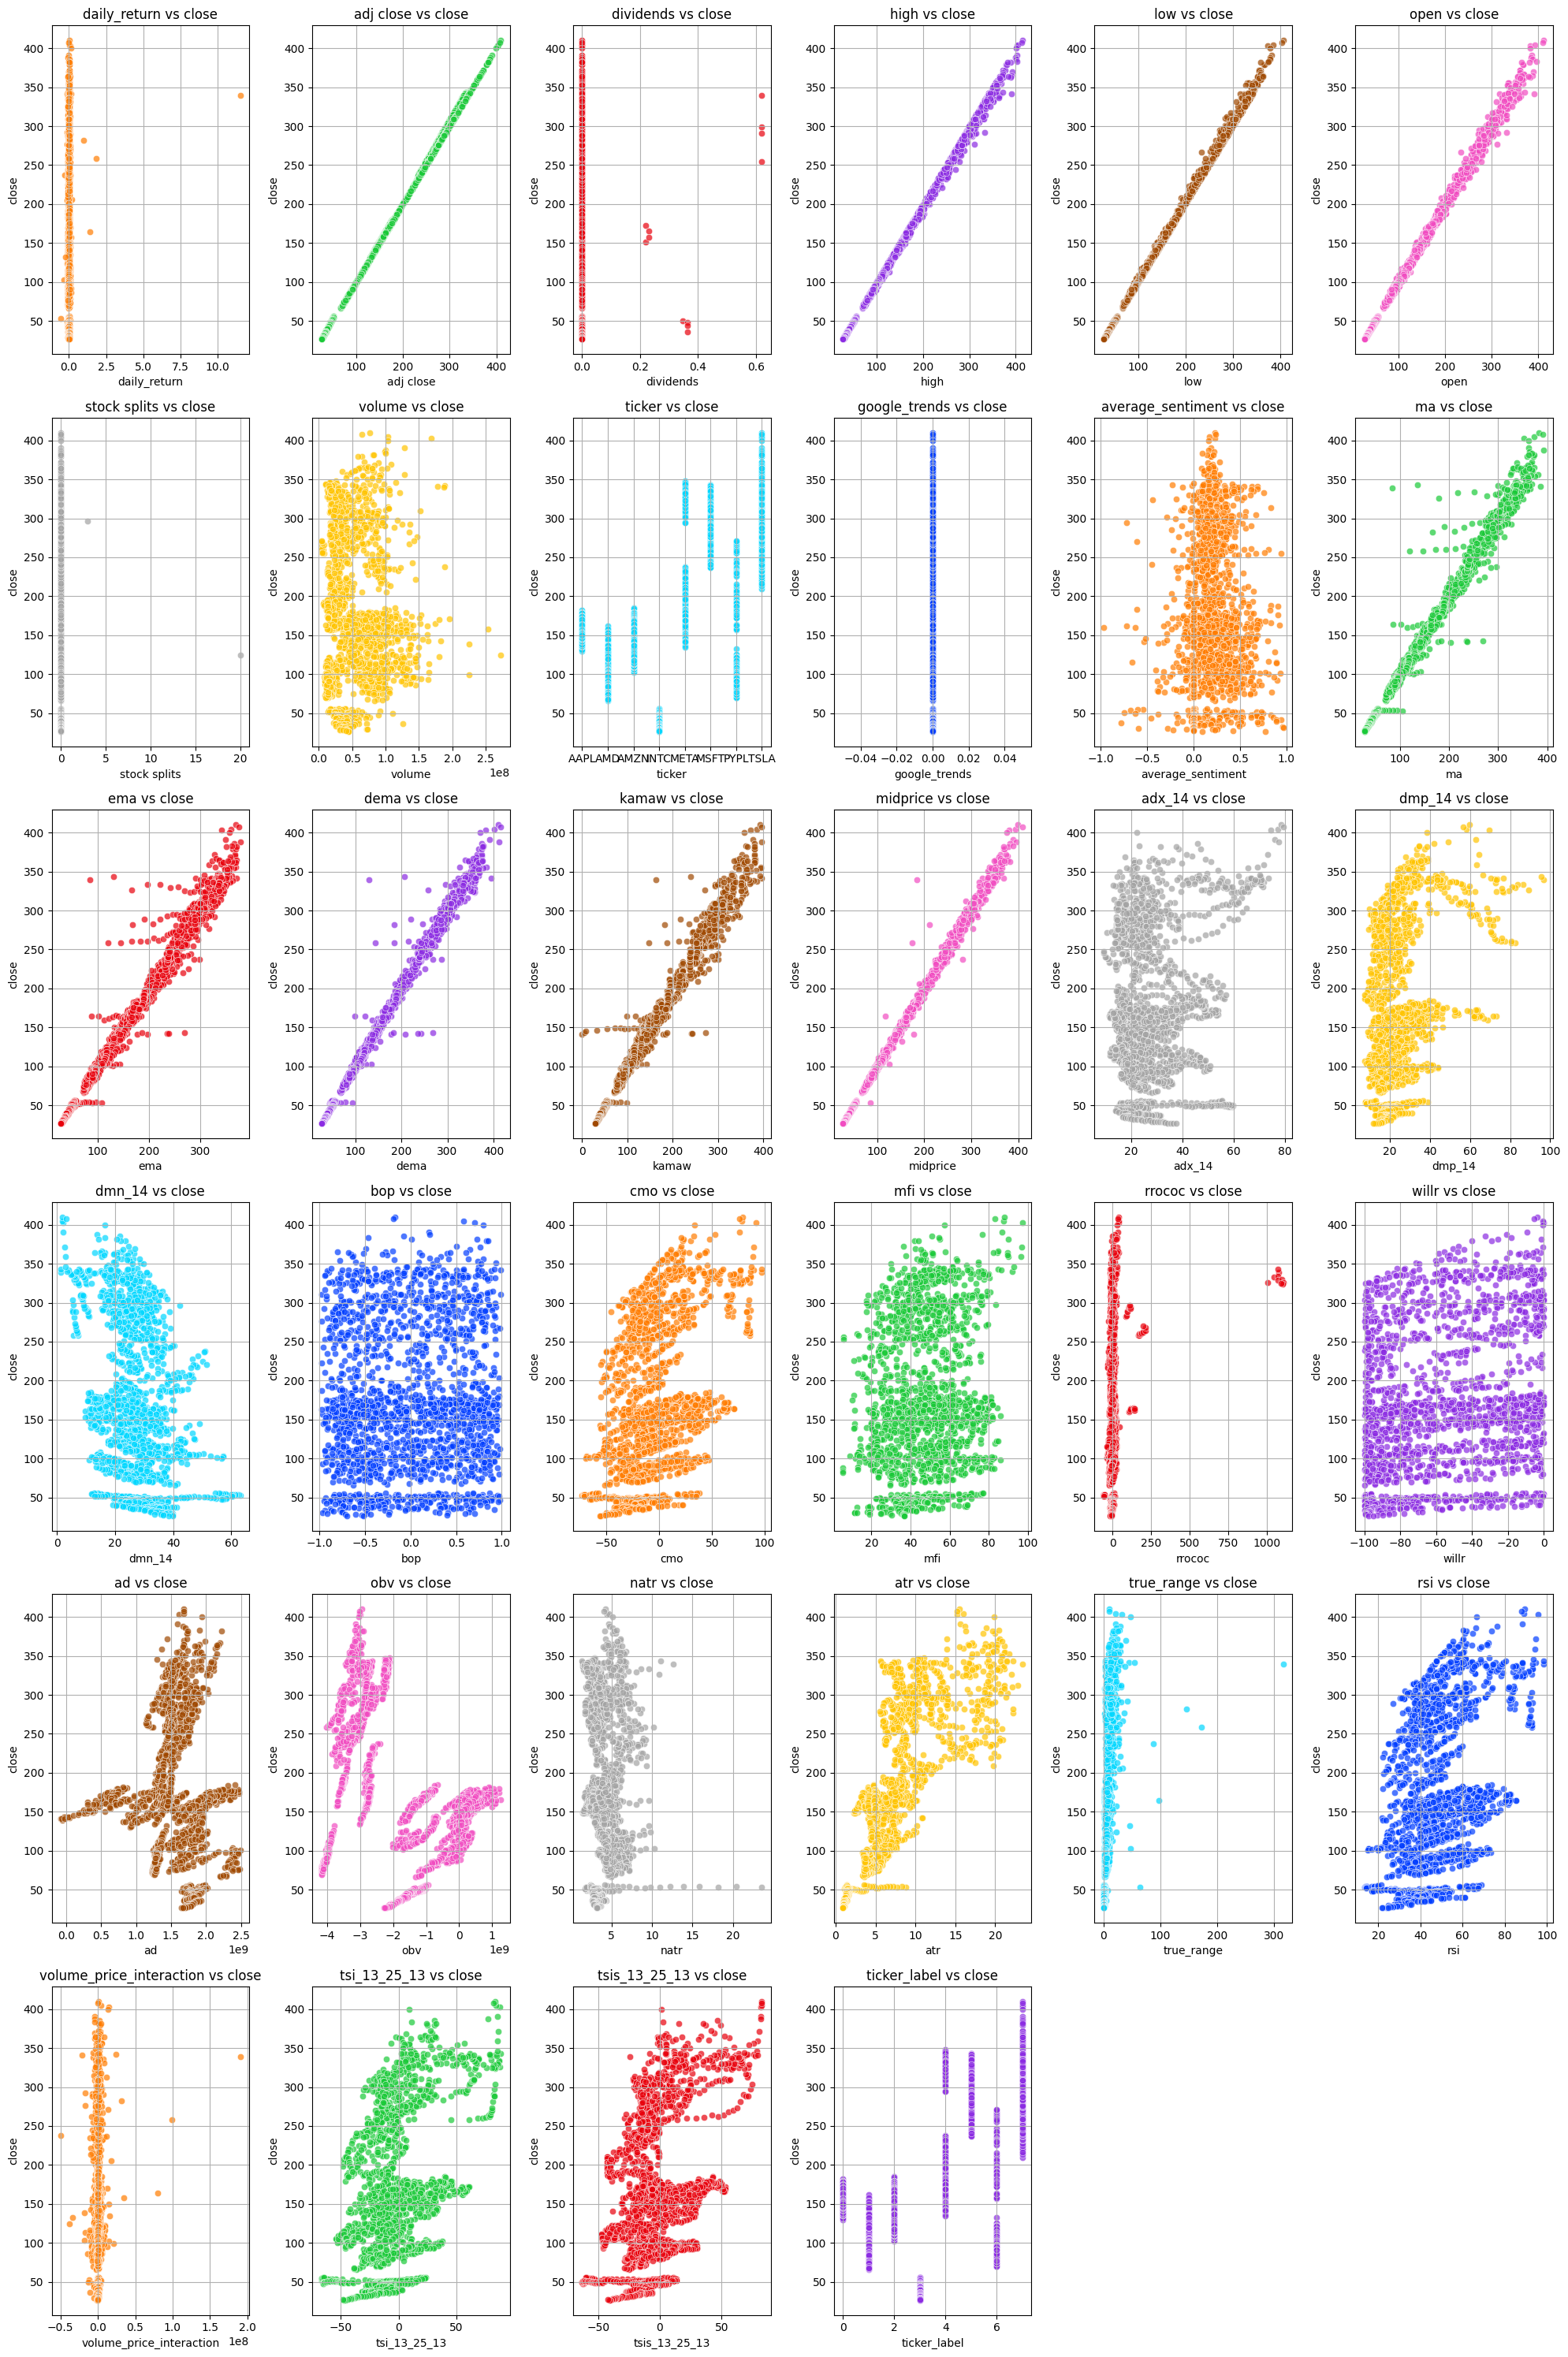

In [2585]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define independent features and the target
Independent_features = [col for col in df_stock_data_final_imp.columns.tolist() if col not in ['close', 'date']]
target = 'close'
# Create subplots for each independent feature vs Daily_Return
plt.figure(figsize=(20, 30))  # Adjust figure size to fit all plots
palette = sns.color_palette("bright")  # Use bright color palette
for i, feature in enumerate(Independent_features, start=1):
    plt.subplot(6, 6, i)  # Create a 6x2 grid for subplots
    sns.scatterplot(
        x=feature,
        y=target,
        data=df_stock_data_final_imp,
        alpha=0.7,
        color=palette[i % len(palette)]  # Cycle through bright colors
    )
    plt.title(f"{feature} vs {target}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)

plt.tight_layout()
plt.show()

## <span style="color:#4682B4">Correlation</span>

The **correlation matrix** is a powerful tool used to measure the relationships between independent variables in a dataset. It helps identify how strongly pairs of variables are linearly related to each other. Correlation values range from **-1 to 1**:
- A value close to **1** indicates a strong positive correlation, meaning as one variable increases, the other tends to increase as well.
- A value close to **-1** indicates a strong negative correlation, where one variable increases as the other decreases.
- A value around **0** indicates little to no linear relationship between the variables.

### Importance of the Correlation Matrix:
1. **Identify Multicollinearity**: If two or more independent variables are highly correlated, it can lead to multicollinearity, which can negatively impact the model’s performance. High multicollinearity makes it difficult to determine the individual effect of each variable on the dependent variable.
   
2. **Feature Selection**: By analyzing the correlation matrix, we can detect variables that are redundant or too closely related to others. This helps in deciding which features to retain and which to drop for building a simpler and more efficient model.

3. **Insights into Relationships**: Understanding correlations helps in interpreting the underlying relationships in the data. For example, we can see how features like **temperature** and **atemp** (feels-like temperature) are closely related, which allows us to make more informed decisions on feature engineering and selection.

By using the correlation matrix effectively, we can reduce redundancy in the dataset, improve model performance, and gain insights into the relationships between variables, making it a critical step in the data preprocessing phase.

In [2561]:
df_stock_data_final_imp.head()

date  daily_return   adj close       close  dividends        high  \
0 2021-09-30      0.006278  139.016602  141.500000        0.0  144.380005   
1 2021-10-01      0.008127  140.146408  142.649994        0.0  142.919998   
4 2021-10-04     -0.024606  136.697983  139.139999        0.0  142.210007   
5 2021-10-05      0.014158  138.633453  141.110001        0.0  142.240005   
6 2021-10-06      0.006307  139.507812  142.000000        0.0  142.149994   

          low        open  stock splits    volume  ...            ad  \
0  141.279999  143.660004           0.0  89056700  ... -7.641635e+07   
1  139.110001  141.899994           0.0  94639600  ...  4.809544e+06   
4  138.270004  141.759995           0.0  98322000  ... -5.009134e+07   
5  139.360001  139.490005           0.0  80861100  ... -3.268390e+07   
6  138.369995  139.470001           0.0  83221100  ...  4.393261e+07   

           obv      natr        atr  true_range        rsi  \
0   89056700.0  4.170424   7.301378    7.331775  48.492967   
1  183696300.0  4.659334  10.727475    3.809998  61.266797   
4   85374300.0  4.731580   6.466940    4.379990  39.787884   
5  166235400.0  3.130105   7.960814    3.100006  61.306032   
6  249456500.0  4.308849  10.853074    3.779999  47.983564   

   volume_price_interaction  tsi_13_25_13  tsis_13_25_13  ticker_label  
0              1.088321e+05     -2.556374      -2.479374             0  
1              7.691517e+05     14.416719      10.406948             0  
4             -2.419276e+06     -8.988521      -7.495520             0  
5              1.144865e+06     15.354422       8.966424             0  
6              5.248865e+05    -14.727058     -14.508166             0  

[5 rows x 36 columns]

In [2562]:
df_stock_data_final_imp.columns

Index(['date', 'daily_return', 'adj close', 'close', 'dividends', 'high',
       'low', 'open', 'stock splits', 'volume', 'ticker', 'google_trends',
       'average_sentiment', 'ma', 'ema', 'dema', 'kamaw', 'midprice', 'adx_14',
       'dmp_14', 'dmn_14', 'bop', 'cmo', 'mfi', 'rrococ', 'willr', 'ad', 'obv',
       'natr', 'atr', 'true_range', 'rsi', 'volume_price_interaction',
       'tsi_13_25_13', 'tsis_13_25_13', 'ticker_label'],
      dtype='object')

Correlation Matrix:
                          date  daily_return  adj close  close  dividends  \
date                      1.00         -0.05      -0.28  -0.28      -0.00   
daily_return             -0.05          1.00       0.05   0.05      -0.01   
adj close                -0.28          0.05       1.00   1.00       0.01   
close                    -0.28          0.05       1.00   1.00       0.01   
dividends                -0.00         -0.01       0.01   0.01       1.00   
high                     -0.28          0.05       1.00   1.00       0.01   
low                      -0.28          0.05       1.00   1.00       0.02   
open                     -0.28          0.05       1.00   1.00       0.01   
stock splits              0.02          0.00      -0.01  -0.01      -0.00   
volume                    0.02         -0.03      -0.03  -0.04      -0.03   
google_trends              NaN           NaN        NaN    NaN        NaN   
average_sentiment        -0.08          0.04       0.09 

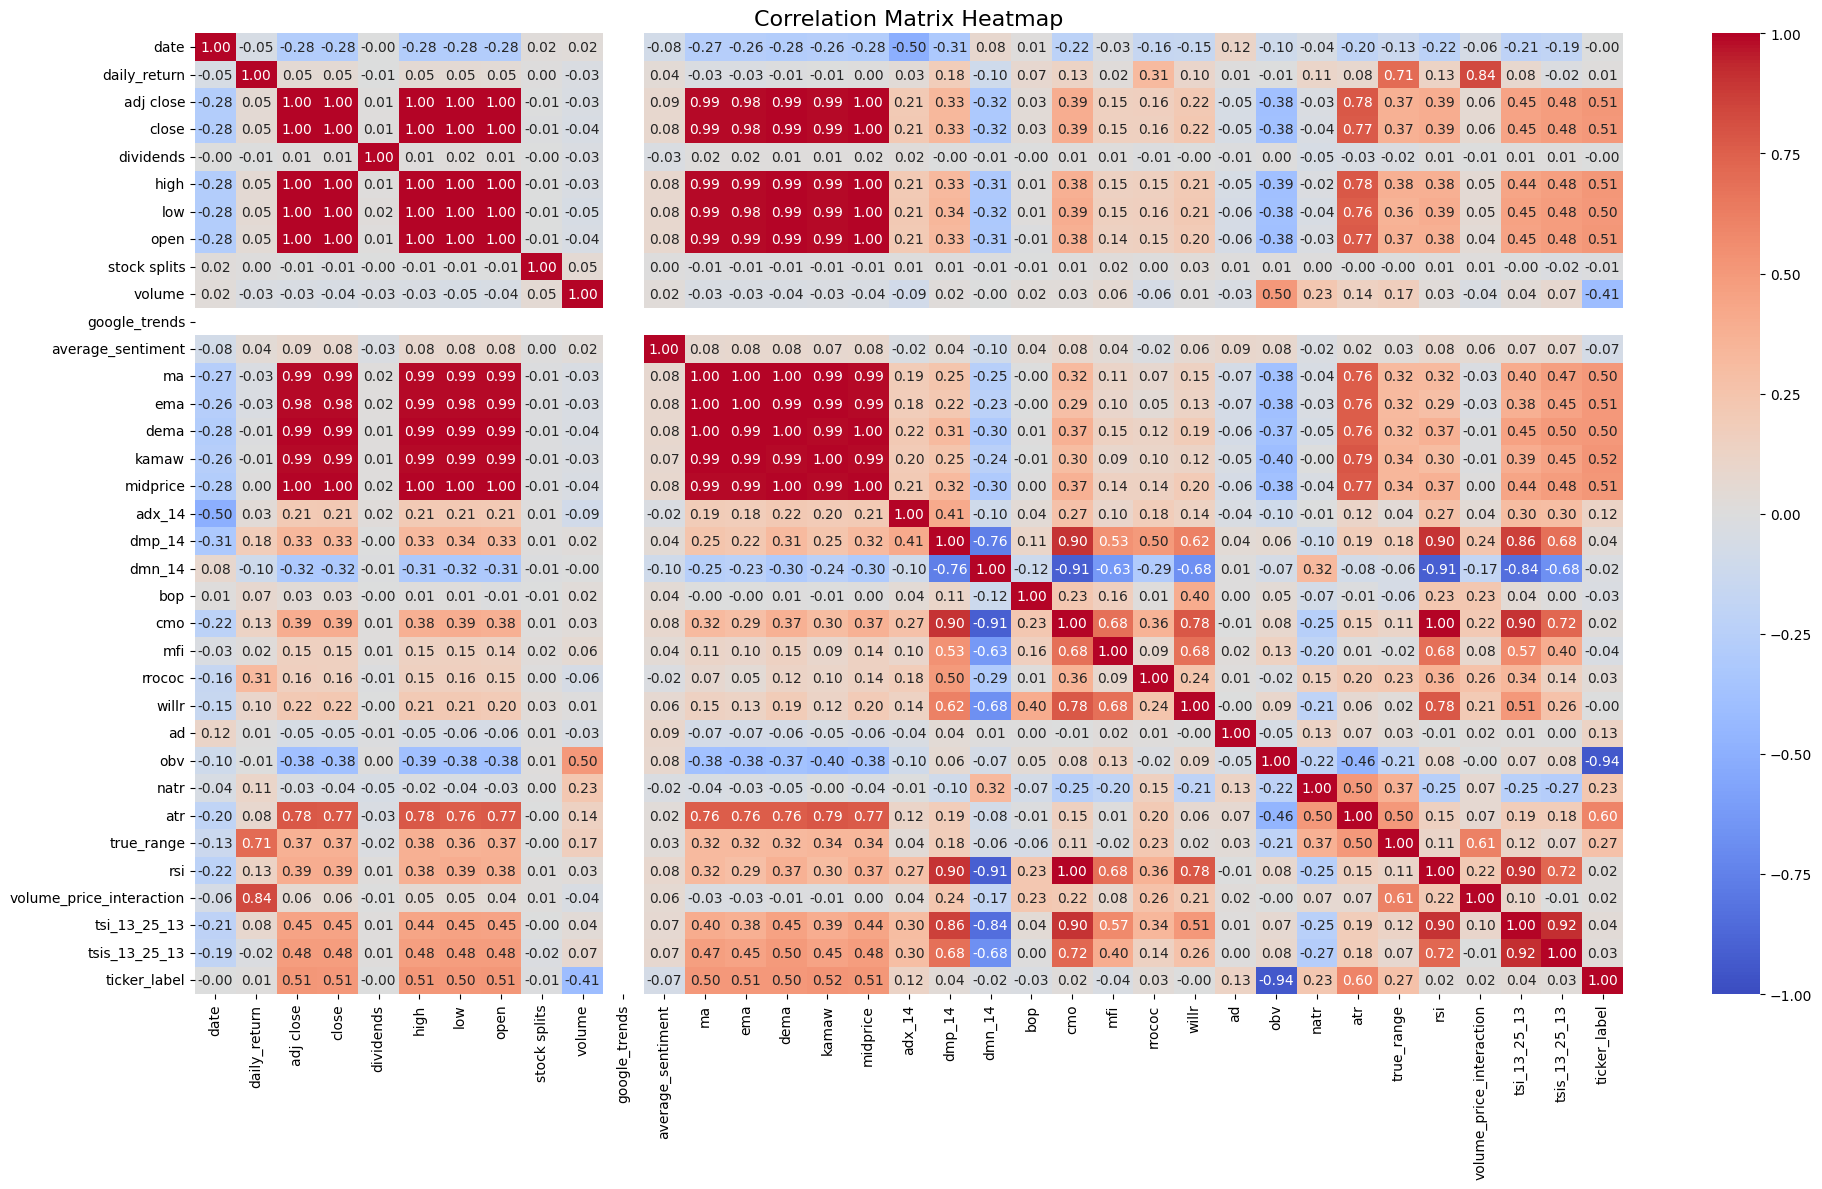

In [2563]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
# Drop 'Ticker' and 'Date' columns from the DataFrame
df_stock_data_final_imp_cleaned = df_stock_data_final_imp.drop(columns=['ticker'])
correlation_matrix = df_stock_data_final_imp_cleaned.corr()
# Display the correlation matrix as a table (rounded to 2 decimal places)
print("Correlation Matrix:")
print(correlation_matrix.round(2))
# Plot the heatmap for the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap', fontsize=16)
# Display the heatmap
plt.tight_layout()
plt.show()

## <span style="color:#4682B4">Key Observations and Recommendations</span>

## Key Observations

### 1. Strong Positive Correlations
| Feature Group         | Correlation with Price Features   | Insights                                                                                  |
|------------------------|------------------------------------|------------------------------------------------------------------------------------------|
| `adj close`, `close`, `high`, `low`, `open` | ≈ 1.00                              | Highly interdependent; redundant information, select one representative feature like `close`. |
| `daily_return`         | 0.73                              | Strongly influenced by price-related features.    
| `ma`,  `ema`       | ≈ 1                              | Highly correlated , we can drop one
| `sma_20` (20-day moving average) | 0.54                              | Valuable for capturing medium-term trends.                                               |
| `volume` and `rsi_volume` | ≈ 0.46                           | Volume-based metrics contribute to price movements.                                       |

### 2. Negative Correlations
| Feature              | Correlation with Price Features | Insights                                                                              |
|-----------------------|---------------------------------|--------------------------------------------------------------------------------------|
| `google_trends`       | -0.40                          | Suggests search trends increase as prices decline, indicating sentiment-related insights. |
| `day_of_week`         | -0.53                          | Weekly patterns impact market activity.                                              |
| `is_weekend`          | -0.68                          | Weekend effect on stock price trends.                                                |
| `volume_price_tatio`  | -0.50                          | Potential for detecting overbought or oversold conditions.                           |
| `weighted_sentiment`  | -0.24                          | Weak negative correlation, but may add sentiment context.                            |

### 3. Weak or Insignificant Correlations
| Feature             | Correlation  | Insights                                                        |
|----------------------|--------------|-----------------------------------------------------------------|
| `dividends`          | ≈ 0.04       | Insignificant for short-term predictions.                       |
| `stock_splits`       | ≈ 0.00       | Little predictive value.                                        |
| `7d_max_volume`      | ≈ 0.00       | Low relevance for stock price predictions.                      |

---

## Recommendations

### 1. Feature Selection
- **Drop** redundant features: `high`, `low`, and `open` (retain `close` or `adj close` as a representative).
- **Drop** redundant features: `ma`, `ema`, retain one
- **Exclude** features with weak correlations: `dividends`, `stock_splits`, and `7d_max_volume`.
- **Retain** features with meaningful dynamics: `daily_return`, `sma_20`, `rsi_volume`, and `volume_price_tatio`.

### 2. Feature Transformation
- Create **lagged features** for `google_trends`, `volume`, and `daily_return` to capture temporal dependencies.
- Use **moving averages** for `volume` and `weighted_sentiment` to smooth short-term volatility and highlight trends.

### 3. Sentiment Features
- Investigate the relationship between `google_trends` and stock prices. Combine with `average_sentiment` or `weighted_sentiment` to uncover hidden patterns.

### 4. Time-Based Features
- Retain **`day_of_week`** and **`is_weekend`** to capture weekly seasonality effects in stock price movements.

### 5. Dimensionality Reduction
- Apply **PCA** to combine highly correlated features (e.g., price-related features) into fewer components while retaining variance.

### 6. Multicollinearity Handling
- Use **Ridge Regression** or **Lasso Regression** to mitigate multicollinearity caused by strongly correlated features.

---

## Conclusion
Focus on retaining features with strong or moderate correlations while engineering temporal and aggregated features (e.g., moving averages, lagged features). Remove features with weak correlations to simplify the model and improve interpretability. Sentiment-based features (`google_trends` and `weighted_sentiment`) could be valuable for identifying market sentiment and its impact on price trends.

## <span style="color:#4682B4">Importance of StandardScaler and PCA</span>

### StandardScaler
**StandardScaler** is a preprocessing technique used to standardize features by removing the mean and scaling them to unit variance. It ensures that each feature contributes equally to the model and prevents bias toward features with larger values. Here’s why it’s important:

1. **Normalization of Features**:
   - Different features in the dataset may have varying scales. For example, temperature may be measured in degrees, while wind speed is measured in meters per second. Without scaling, features with larger values might dominate the learning process, leading to biased predictions.
   
2. **Model Performance**:
   - Many machine learning algorithms, especially those that use distance metrics (like **k-nearest neighbors** or **support vector machines**), perform better when features are on a similar scale. **StandardScaler** ensures that all features contribute equally to the model.

3. **Stability of Coefficients**:
   - Scaling improves the stability of the model coefficients, especially in models like **linear regression** and **logistic regression**, where coefficients represent the influence of each feature on the target variable. Unscaled features may lead to large coefficients, which are harder to interpret and can cause overfitting.

---

### Principal Component Analysis (PCA)
**Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms the original set of features into a new set of uncorrelated features, called **principal components**. These components capture the most important information from the original features. Here’s why PCA is important:

1. **Reducing Dimensionality**:
   - High-dimensional datasets can be difficult to work with and can lead to overfitting. PCA helps by reducing the number of features while retaining as much variance (information) as possible. This simplifies the dataset and improves model efficiency.

2. **Eliminating Redundancy**:
   - PCA helps in eliminating multicollinearity by creating new, uncorrelated features (principal components). This is particularly useful when the original features are highly correlated, as PCA focuses on capturing the most meaningful information from the data.

3. **Improving Computational Efficiency**:
   - By reducing the dimensionality of the dataset, PCA reduces the computational burden on machine learning algorithms, especially for large datasets. This leads to faster training and prediction times without sacrificing much accuracy.

4. **Visualizing High-Dimensional Data**:
   - PCA allows us to visualize high-dimensional data in 2D or 3D, making it easier to understand patterns and relationships in the data that would otherwise be difficult to interpret.

By using **StandardScaler** and **PCA** together, we can ensure that the dataset is properly scaled and that only the most important features are retained for model training, leading to a more efficient and accurate predictive model.

In [2564]:
df_stock_data_final_imp_cleaned.columns

Index(['date', 'daily_return', 'adj close', 'close', 'dividends', 'high',
       'low', 'open', 'stock splits', 'volume', 'google_trends',
       'average_sentiment', 'ma', 'ema', 'dema', 'kamaw', 'midprice', 'adx_14',
       'dmp_14', 'dmn_14', 'bop', 'cmo', 'mfi', 'rrococ', 'willr', 'ad', 'obv',
       'natr', 'atr', 'true_range', 'rsi', 'volume_price_interaction',
       'tsi_13_25_13', 'tsis_13_25_13', 'ticker_label'],
      dtype='object')

In [2577]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
df_stock_data_final_imp_cleaned = df_stock_data_final_imp.drop(columns=['ma', 'ema', 'dema', 'kamaw'])
# Define the features to combine (price-related features)
price_features = ['high', 'low', 'open']
non_price_features = ['daily_return', 'close', 'dividends', 'stock splits', 'volume', 'google_trends',
       'average_sentiment', 'midprice', 'adx_14',
       'dmp_14', 'dmn_14', 'bop', 'cmo', 'mfi', 'rrococ', 'willr', 'ad', 'obv',
       'natr', 'atr', 'true_range', 'rsi', 'tsi_13_25_13', 'tsis_13_25_13',
       'ticker_label']

# Separate the price-related features
price_data = df_stock_data_final_imp_cleaned[price_features]
# Standardize the price-related features
scaler = StandardScaler()
price_data_scaled = scaler.fit_transform(price_data)
# Apply PCA to combine price-related features
pca = PCA(n_components=2)  # Retain 2 principal components
price_pca = pca.fit_transform(price_data_scaled)
# Create a DataFrame for the PCA components
price_pca_df = pd.DataFrame(price_pca, columns=['price_pc1', 'price_pc2'])
# Concatenate the PCA components with the remaining features
non_price_data = df_stock_data_final_imp_cleaned[non_price_features]
df_stock_data_pca = pd.concat([non_price_data.reset_index(drop=True), price_pca_df.reset_index(drop=True)], axis=1)
# Display the explained variance ratio for PCA components
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for Price Components:")
for i, var in enumerate(explained_variance_ratio, start=1):
 print(f"Price_PC{i}: {var:.4f}")
# Show the first few rows of the transformed DataFrame
df_stock_data_pca.head()

Explained Variance Ratio for Price Components:
Price_PC1: 0.9995
Price_PC2: 0.0003


daily_return       close  dividends  stock splits    volume  google_trends  \
0      0.006278  141.500000        0.0           0.0  89056700              0   
1      0.008127  142.649994        0.0           0.0  94639600              0   
2     -0.024606  139.139999        0.0           0.0  98322000              0   
3      0.014158  141.110001        0.0           0.0  80861100              0   
4      0.006307  142.000000        0.0           0.0  83221100              0   

   average_sentiment    midprice     adx_14     dmp_14  ...          obv  \
0           0.098900  176.917852  27.535055  24.678518  ...   89056700.0   
1           0.248255  141.745003  32.263659  37.189038  ...  183696300.0   
2           0.122830  140.595001  28.133316  19.294579  ...   85374300.0   
3           0.331000  140.255005  24.482109  35.050925  ...  166235400.0   
4           0.243520  140.305000  29.144991  21.598148  ...  249456500.0   

       natr        atr  true_range        rsi  tsi_13_25_13  tsis_13_25_13  \
0  4.170424   7.301378    7.331775  48.492967     -2.556374      -2.479374   
1  4.659334  10.727475    3.809998  61.266797     14.416719      10.406948   
2  4.731580   6.466940    4.379990  39.787884     -8.988521      -7.495520   
3  3.130105   7.960814    3.100006  61.306032     15.354422       8.966424   
4  4.308849  10.853074    3.779999  47.983564    -14.727058     -14.508166   

   ticker_label  price_pc1  price_pc2  
0             0  -0.628309   0.012120  
1             0  -0.661716   0.006399  
2             0  -0.672184   0.003420  
3             0  -0.679162   0.019395  
4             0  -0.686065   0.011289  

[5 rows x 27 columns]

Correlation Matrix:
                   daily_return  close  dividends  stock splits  volume  \
daily_return               1.00   0.05      -0.01          0.00   -0.03   
close                      0.05   1.00       0.01         -0.01   -0.04   
dividends                 -0.01   0.01       1.00         -0.00   -0.03   
stock splits               0.00  -0.01      -0.00          1.00    0.05   
volume                    -0.03  -0.04      -0.03          0.05    1.00   
google_trends               NaN    NaN        NaN           NaN     NaN   
average_sentiment          0.04   0.08      -0.03          0.00    0.02   
midprice                   0.00   1.00       0.02         -0.01   -0.04   
adx_14                     0.03   0.21       0.02          0.01   -0.09   
dmp_14                     0.18   0.33      -0.00          0.01    0.02   
dmn_14                    -0.10  -0.32      -0.01         -0.01   -0.00   
bop                        0.07   0.03      -0.00         -0.01    0.02   
cmo  

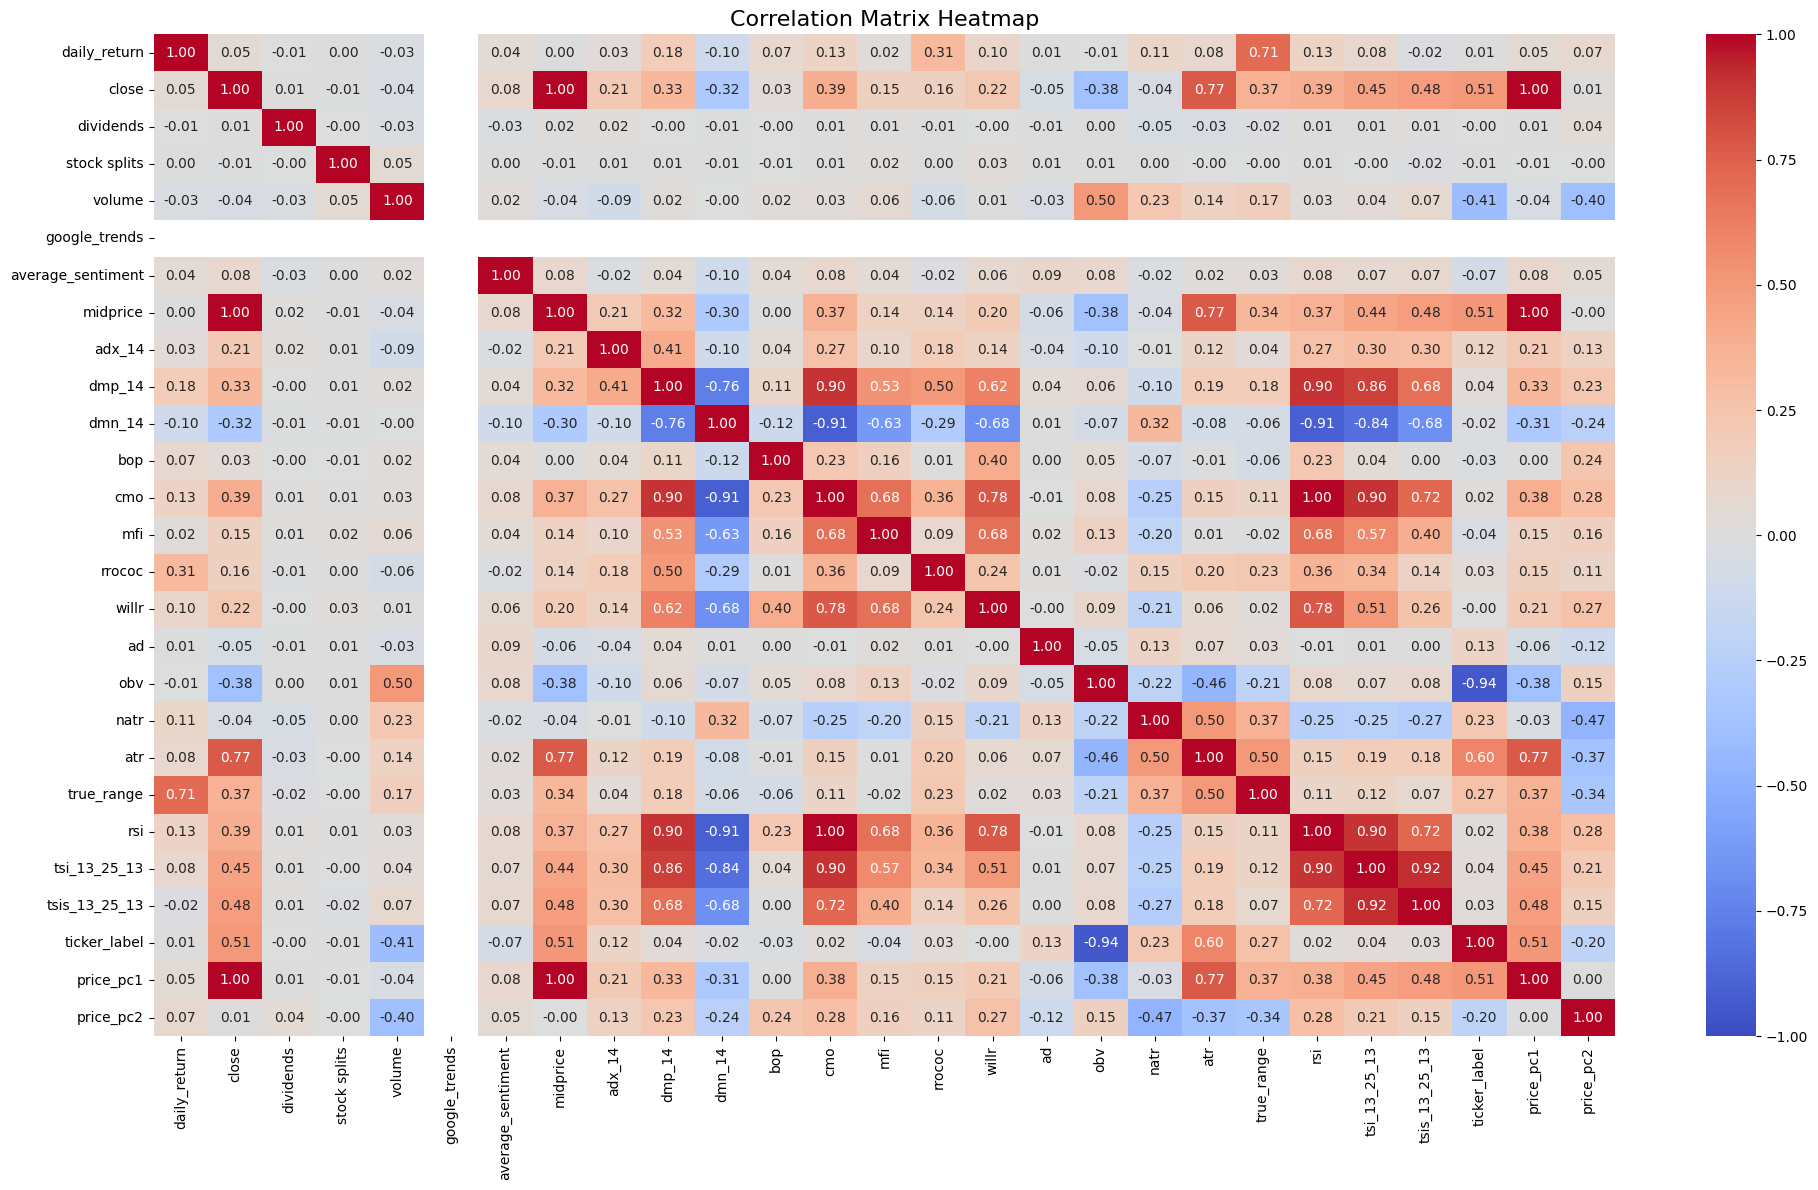

In [2578]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
# Drop 'Ticker' and 'Date' columns from the DataFrame
#data_tesla_cleaned = data_tesla_pca.drop(columns=['ticker', 'date'])
correlation_matrix = df_stock_data_pca.corr()
# Display the correlation matrix as a table (rounded to 2 decimal places)
print("Correlation Matrix:")
print(correlation_matrix.round(2))
# Plot the heatmap for the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap', fontsize=16)
# Display the heatmap
plt.tight_layout()
plt.show()

In [2579]:

df_stock_data_pca.head()

daily_return       close  dividends  stock splits    volume  google_trends  \
0      0.006278  141.500000        0.0           0.0  89056700              0   
1      0.008127  142.649994        0.0           0.0  94639600              0   
2     -0.024606  139.139999        0.0           0.0  98322000              0   
3      0.014158  141.110001        0.0           0.0  80861100              0   
4      0.006307  142.000000        0.0           0.0  83221100              0   

   average_sentiment    midprice     adx_14     dmp_14  ...          obv  \
0           0.098900  176.917852  27.535055  24.678518  ...   89056700.0   
1           0.248255  141.745003  32.263659  37.189038  ...  183696300.0   
2           0.122830  140.595001  28.133316  19.294579  ...   85374300.0   
3           0.331000  140.255005  24.482109  35.050925  ...  166235400.0   
4           0.243520  140.305000  29.144991  21.598148  ...  249456500.0   

       natr        atr  true_range        rsi  tsi_13_25_13  tsis_13_25_13  \
0  4.170424   7.301378    7.331775  48.492967     -2.556374      -2.479374   
1  4.659334  10.727475    3.809998  61.266797     14.416719      10.406948   
2  4.731580   6.466940    4.379990  39.787884     -8.988521      -7.495520   
3  3.130105   7.960814    3.100006  61.306032     15.354422       8.966424   
4  4.308849  10.853074    3.779999  47.983564    -14.727058     -14.508166   

   ticker_label  price_pc1  price_pc2  
0             0  -0.628309   0.012120  
1             0  -0.661716   0.006399  
2             0  -0.672184   0.003420  
3             0  -0.679162   0.019395  
4             0  -0.686065   0.011289  

[5 rows x 27 columns]

Processing stock: AAPL
Training LSTM model for stock: AAPL
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.9720 - val_loss: 0.6774
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6052 - val_loss: 0.5309
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3383 - val_loss: 0.3479
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2496 - val_loss: 0.1775
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1547 - val_loss: 0.1330
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1302 - val_loss: 0.1016
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0982 - val_loss: 0.0766
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0860 - val_loss: 0.0625
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0714 - val_loss: 0.0584
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0758 - val_loss: 0.0612
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0537 - val_loss: 0.0554
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━

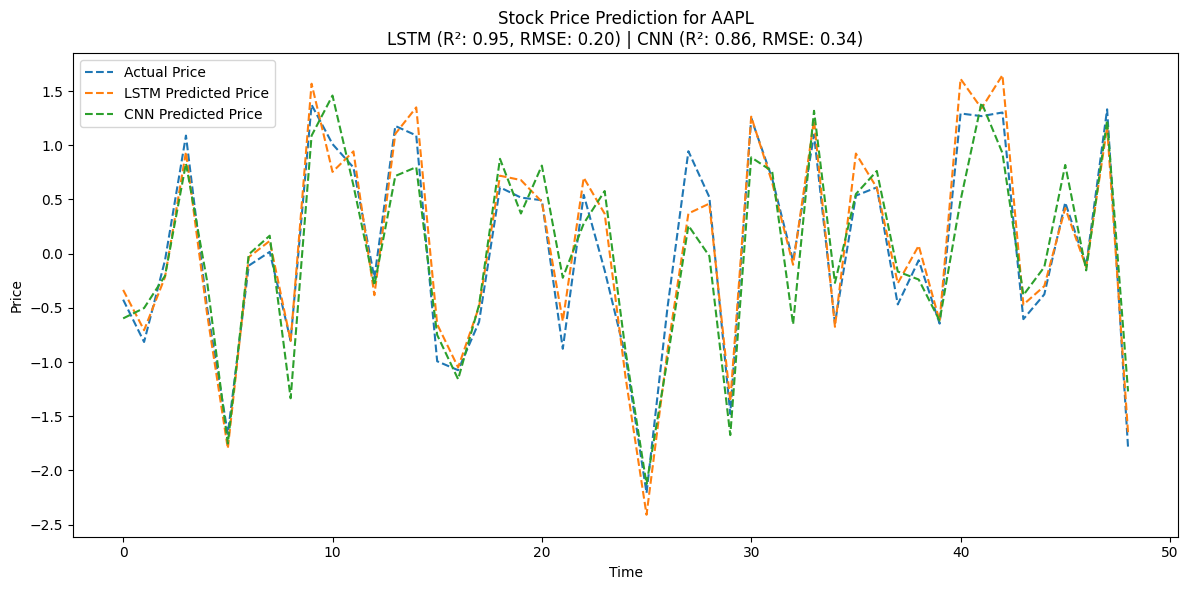

Processing stock: AMD
Training LSTM model for stock: AMD
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.7835 - val_loss: 0.4215
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3849 - val_loss: 0.2350
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3072 - val_loss: 0.1481
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1742 - val_loss: 0.1167
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1309 - val_loss: 0.0888
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0946 - val_loss: 0.0734
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0607 - val_loss: 0.0522
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0525 - val_loss: 0.0438
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0378 - val_loss: 0.0402
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0374 - val_loss: 0.0369
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0370 - val_loss: 0.0336
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━

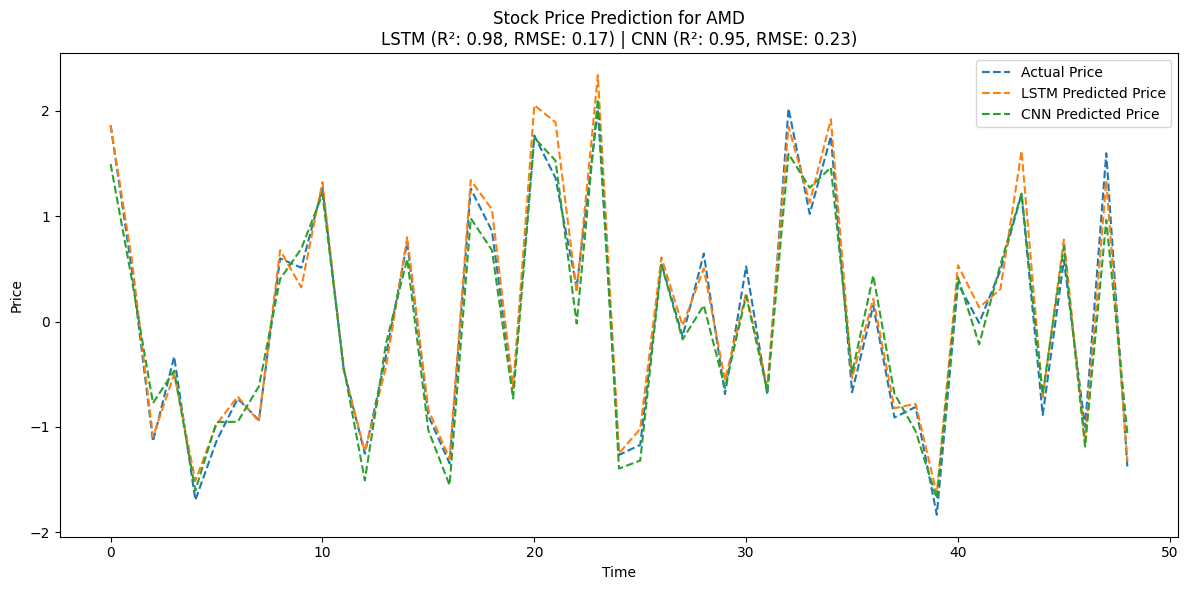

Processing stock: AMZN
Training LSTM model for stock: AMZN
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.8346 - val_loss: 0.5544
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5878 - val_loss: 0.3315
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3054 - val_loss: 0.1901
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1900 - val_loss: 0.1565
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1594 - val_loss: 0.1259
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1004 - val_loss: 0.0827
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0824 - val_loss: 0.0689
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0691 - val_loss: 0.0530
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0508 - val_loss: 0.0438
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0459 - val_loss: 0.0389
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0377 - val_loss: 0.0303
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━

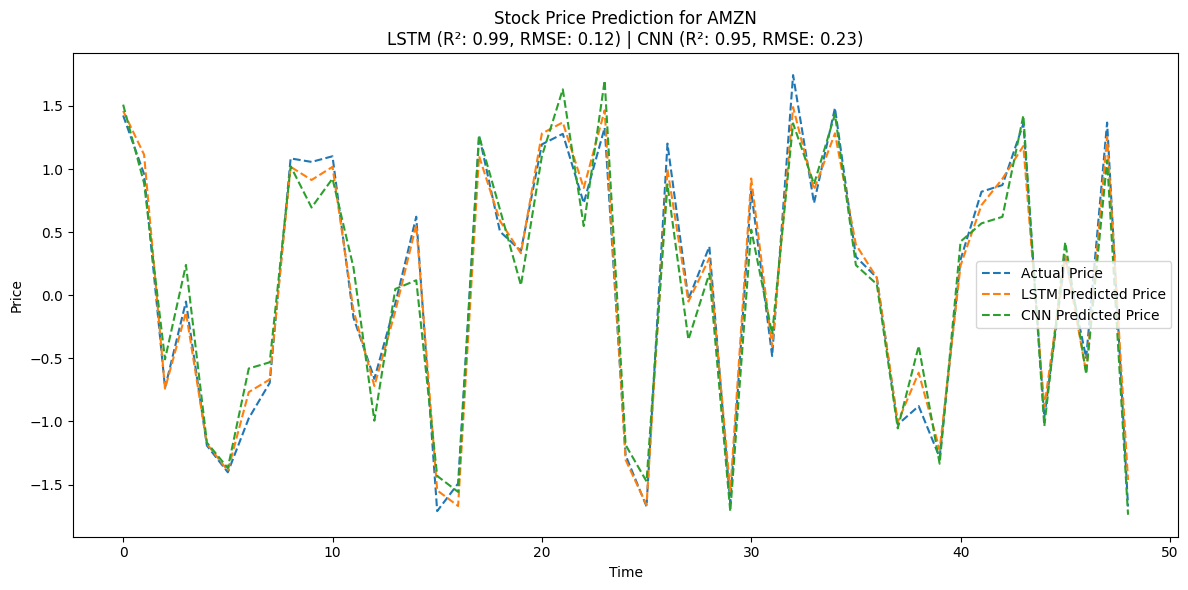

Processing stock: INTC
Training LSTM model for stock: INTC
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.7464 - val_loss: 0.4391
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3153 - val_loss: 0.2223
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1422 - val_loss: 0.1264
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0752 - val_loss: 0.0817
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0718 - val_loss: 0.0502
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0418 - val_loss: 0.0496
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0337 - val_loss: 0.0467
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0273 - val_loss: 0.0400
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210 - val_loss: 0.0351
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217 - val_loss: 0.0330
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - val_loss: 0.0329
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━

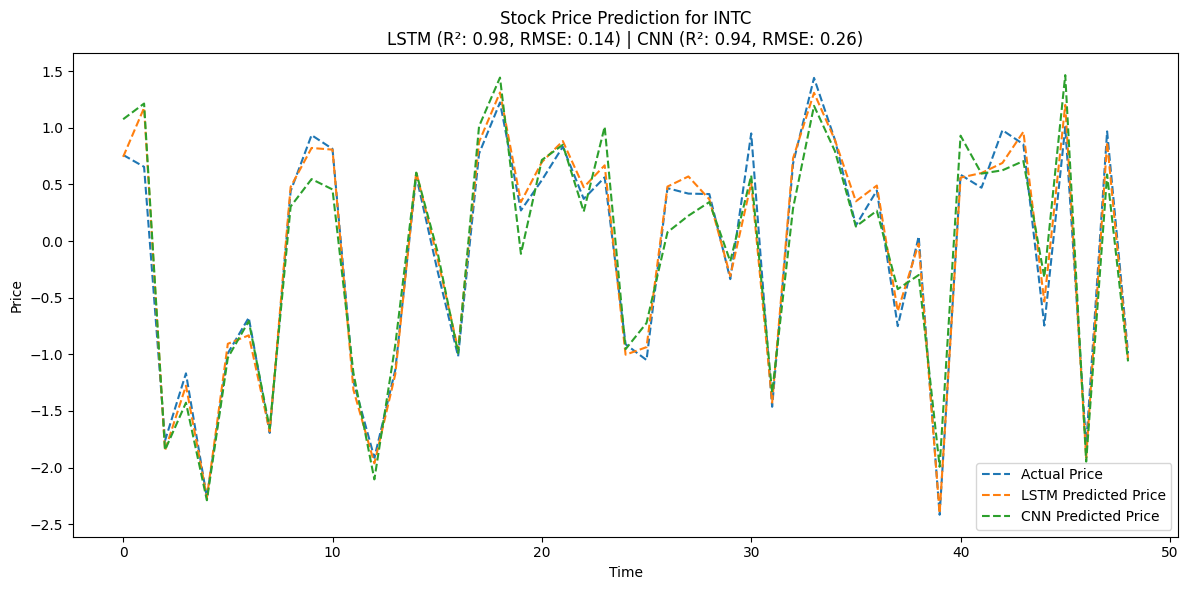

Processing stock: META
Training LSTM model for stock: META
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.8490 - val_loss: 0.5039
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4454 - val_loss: 0.2270
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1755 - val_loss: 0.1114
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0943 - val_loss: 0.0515
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0574 - val_loss: 0.0384
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0416 - val_loss: 0.0354
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0384 - val_loss: 0.0332
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0301 - val_loss: 0.0356
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0209 - val_loss: 0.0291
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0228 - val_loss: 0.0233
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 - val_loss: 0.0210
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━

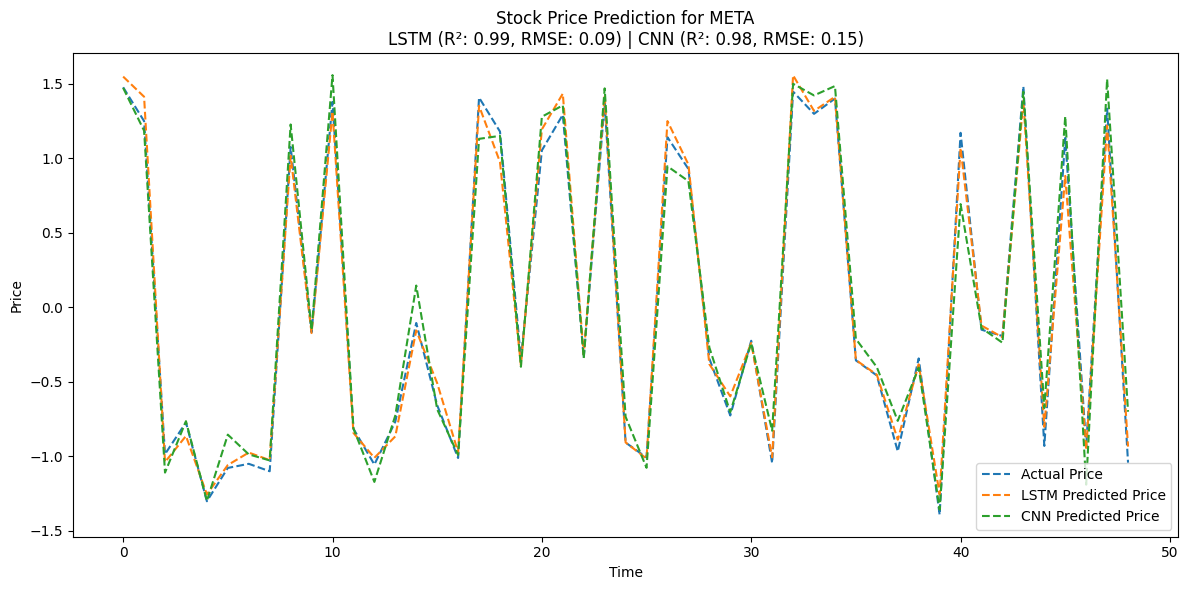

Processing stock: MSFT
Training LSTM model for stock: MSFT
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.9829 - val_loss: 0.4530
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5578 - val_loss: 0.2507
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2895 - val_loss: 0.2175
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2503 - val_loss: 0.1182
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1389 - val_loss: 0.0723
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0895 - val_loss: 0.0754
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0869 - val_loss: 0.0621
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0767 - val_loss: 0.0482
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0756 - val_loss: 0.0460
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0610 - val_loss: 0.0508
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0520 - val_loss: 0.0329
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━

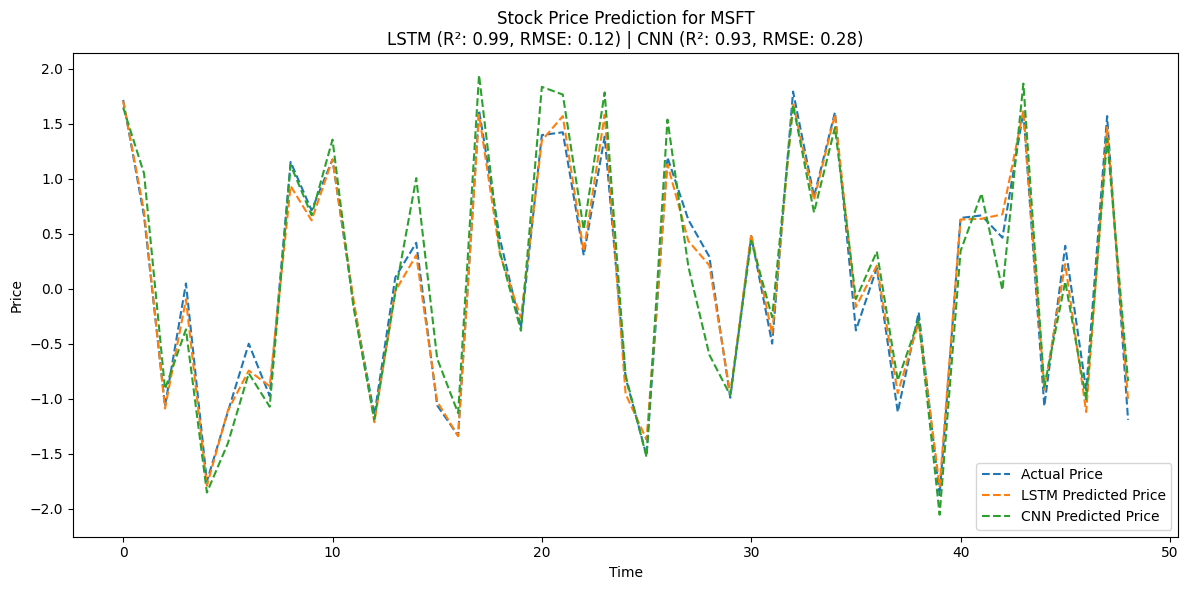

Processing stock: PYPL
Training LSTM model for stock: PYPL
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.9496 - val_loss: 0.5875
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5145 - val_loss: 0.3181
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2788 - val_loss: 0.0987
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1184 - val_loss: 0.0494
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0574 - val_loss: 0.0599
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0427 - val_loss: 0.0485
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0453 - val_loss: 0.0255
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - val_loss: 0.0225
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188 - val_loss: 0.0184
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - val_loss: 0.0133
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━

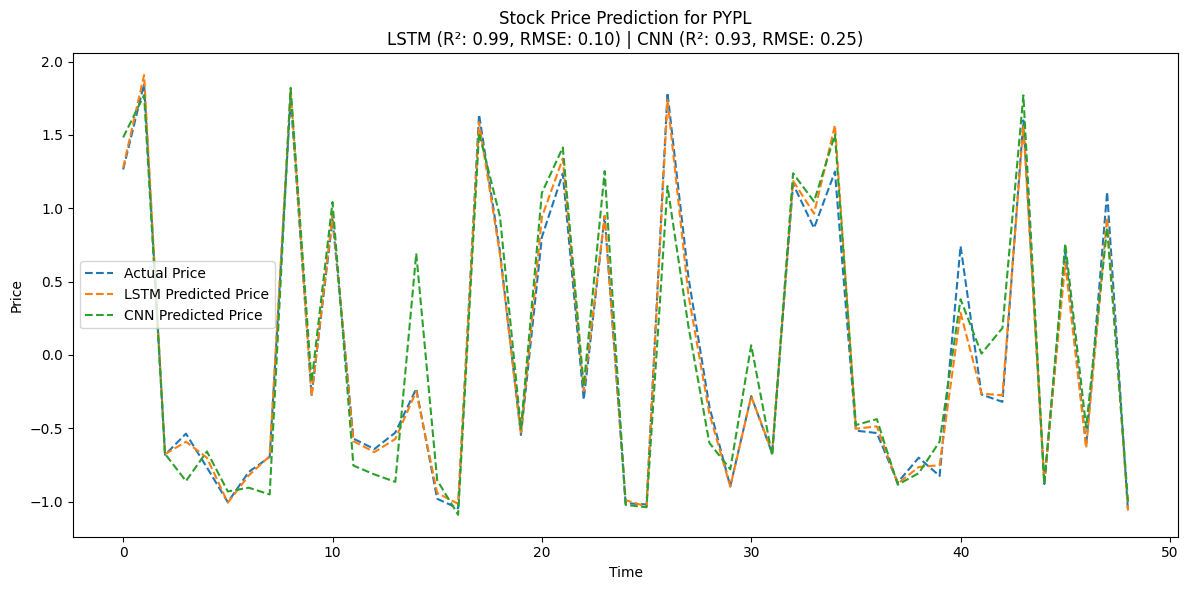

Processing stock: TSLA
Training LSTM model for stock: TSLA
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.8852 - val_loss: 0.5060
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5672 - val_loss: 0.3112
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2686 - val_loss: 0.2347
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2181 - val_loss: 0.1818
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1514 - val_loss: 0.1609
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1507 - val_loss: 0.1348
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1184 - val_loss: 0.1089
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0922 - val_loss: 0.1049
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0800 - val_loss: 0.0965
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0760 - val_loss: 0.0855
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0702 - val_loss: 0.0842
Epoch 12/50
6/6 ━━━━━━━━━━━━━

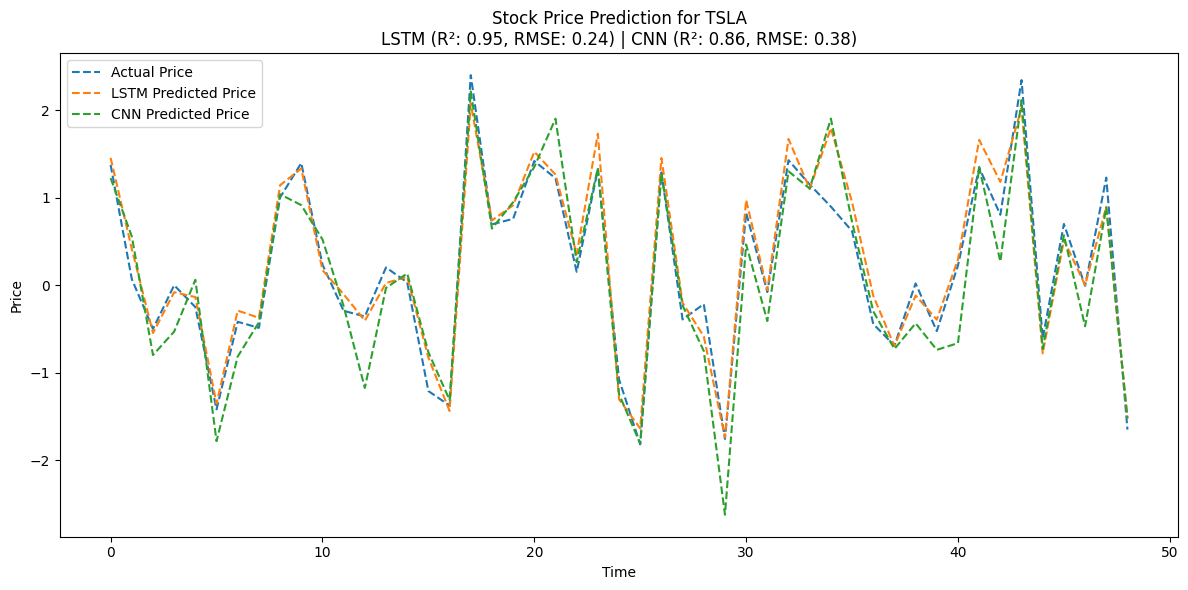

  Stock   LSTM_R²  LSTM_RMSE    CNN_R²  CNN_RMSE
0  AAPL  0.952192   0.200866  0.862276  0.340926
1   AMD  0.975816   0.167331  0.954620  0.229214
2  AMZN  0.987479   0.116530  0.950292  0.232185
3  INTC  0.981107   0.141905  0.935096  0.263018
4  META  0.992201   0.089246  0.977447  0.151767
5  MSFT  0.987727   0.115872  0.926114  0.284303
6  PYPL  0.989556   0.095407  0.927633  0.251143
7  TSLA  0.945357   0.236642  0.860770  0.377738


In [2583]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten
import matplotlib.pyplot as plt

# Placeholder for results
results = []

# Load the dataset (ensure `data_tesla` is defined)
merged_df = df_stock_data_pca
# Clean and standardize column names
merged_df.columns = merged_df.columns.str.strip().str.lower()
# Group by each stock
grouped_stocks = merged_df.groupby('ticker_label')

# Iterate through each stock group
for stock_label, stock_data in grouped_stocks:
    stock_name = tickers[stock_label]  # Map stock_label to the corresponding ticker
    print(f"Processing stock: {stock_name}")
    # Filter and select relevant columns
    Independent_features = [col for col in df_stock_data_pca.columns.tolist() if col not in ['close']]
    target = 'close'  # Target variable
    stock_data = stock_data[Independent_features + [target]].dropna()
    if len(stock_data) < 20:  # Skip if there's not enough data
        print(f"Not enough data for stock {stock_name}. Skipping...")
        continue
    
    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_data, columns=Independent_features + [target])
    
    # Create sequences for LSTM and CNN
    timesteps = 10
    X, y = [], []
    for i in range(timesteps, len(scaled_df)):
        X.append(scaled_df.iloc[i-timesteps:i, :-1].values)
        y.append(scaled_df.iloc[i, -1])
    X, y = np.array(X), np.array(y)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    
    # Define the CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    cnn_model.compile(optimizer='adam', loss='mse')
    
    # Train both models
    print(f"Training LSTM model for stock: {stock_name}")
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    print(f"Training CNN model for stock: {stock_name}")
    cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    # Make predictions for both models
    lstm_y_pred = lstm_model.predict(X_test).flatten()
    cnn_y_pred = cnn_model.predict(X_test).flatten()
    
    # Calculate R² and RMSE for both models
    lstm_r2 = r2_score(y_test, lstm_y_pred)
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_y_pred))
    
    cnn_r2 = r2_score(y_test, cnn_y_pred)
    cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_y_pred))
    
    results.append({
        'Stock': stock_name,
        'LSTM_R²': lstm_r2,
        'LSTM_RMSE': lstm_rmse,
        'CNN_R²': cnn_r2,
        'CNN_RMSE': cnn_rmse
    })
    
    # Plot the results side-by-side
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual Price', linestyle='--')
    plt.plot(lstm_y_pred, label='LSTM Predicted Price', linestyle='--')
    plt.plot(cnn_y_pred, label='CNN Predicted Price', linestyle='--')
    plt.title(f'Stock Price Prediction for {stock_name}\nLSTM (R²: {lstm_r2:.2f}, RMSE: {lstm_rmse:.2f}) | CNN (R²: {cnn_r2:.2f}, RMSE: {cnn_rmse:.2f})')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

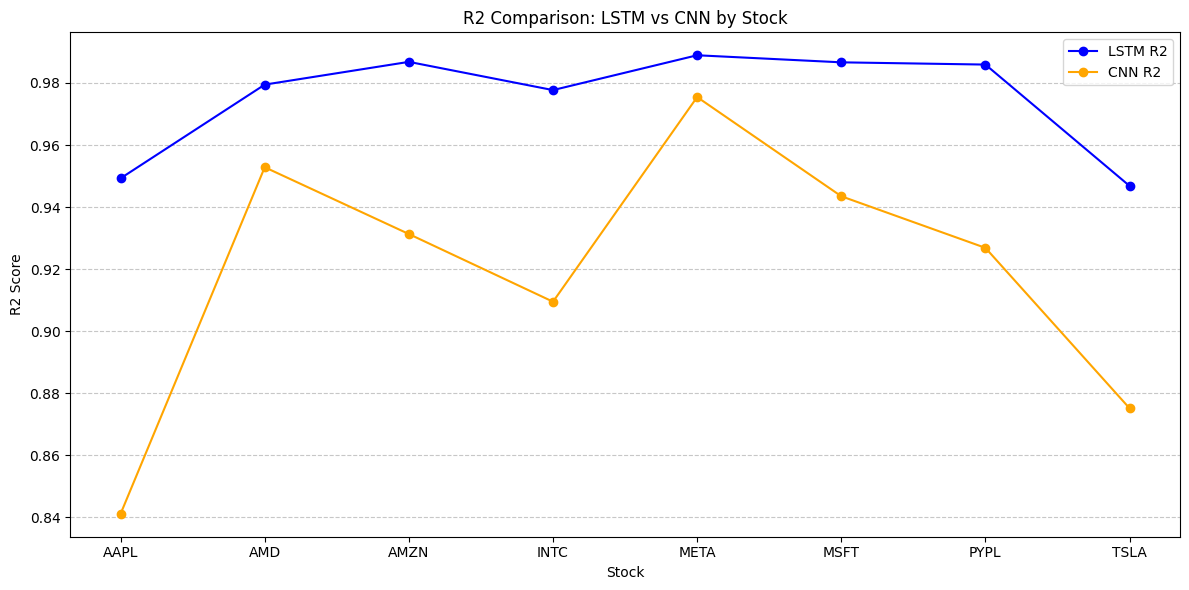

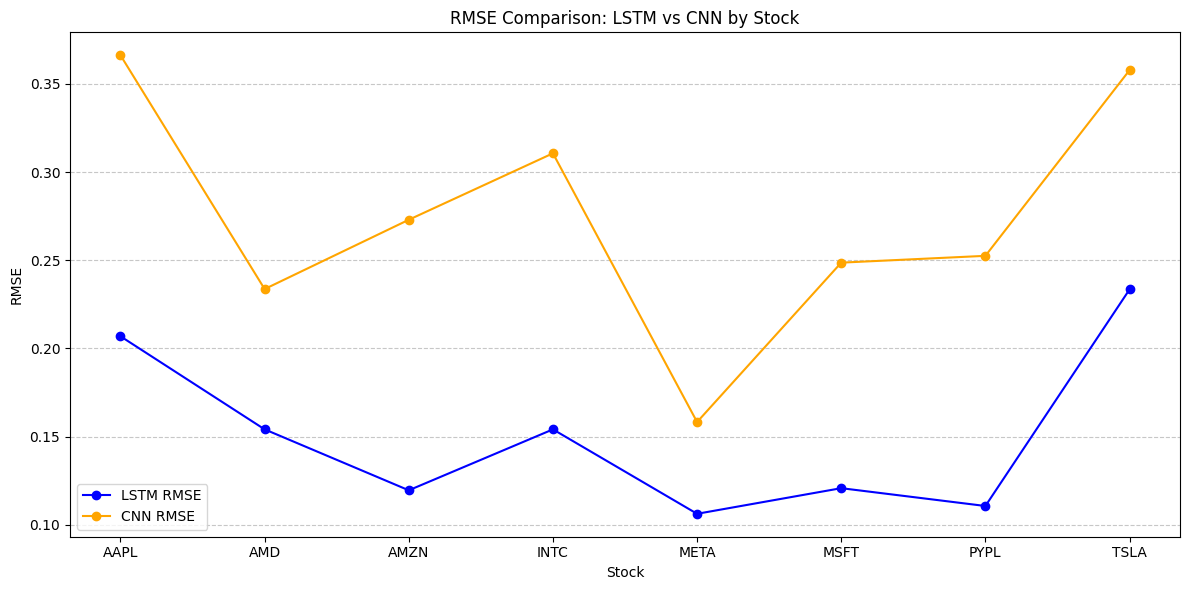

In [2581]:
# Line graph to compare R2 for LSTM and CNN
plt.figure(figsize=(12, 6))
plt.plot(results_df['Stock'], results_df['LSTM_R²'], marker='o', label='LSTM R2', color='blue')
plt.plot(results_df['Stock'], results_df['CNN_R²'], marker='o', label='CNN R2', color='orange')
plt.title("R2 Comparison: LSTM vs CNN by Stock")
plt.xlabel("Stock")
plt.ylabel("R2 Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Line graph to compare RMSE for LSTM and CNN
plt.figure(figsize=(12, 6))
plt.plot(results_df['Stock'], results_df['LSTM_RMSE'], marker='o', label='LSTM RMSE', color='blue')
plt.plot(results_df['Stock'], results_df['CNN_RMSE'], marker='o', label='CNN RMSE', color='orange')
plt.title("RMSE Comparison: LSTM vs CNN by Stock")
plt.xlabel("Stock")
plt.ylabel("RMSE")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## <span style="color:#4682B4">LSTM vs CNN Stock Price Prediction</span>

The performance of both **LSTM** and **CNN** models for predicting stock prices was evaluated using **R² (coefficient of determination)** and **RMSE (root mean squared error)** metrics across eight prominent stocks: AAPL, AMD, AMZN, INTC, META, MSFT, PYPL, and TSLA. Both models performed well overall, with LSTM consistently achieving lower RMSE and higher R² values compared to CNN

---

#### Stock-Wise Observations:

1. **AAPL**:
   - **LSTM**: \( R^2 = 0.952 \), RMSE = 0.201
   - **CNN**: \( R^2 = 0.862 \), RMSE = 0.341
   - **Conclusion**: LSTM performs significantly better for AAPL, capturing variance more effectively and reducing error.

2. **AMD**:
   - **LSTM**: \( R^2 = 0.976 \), RMSE = 0.167
   - **CNN**: \( R^2 = 0.955 \), RMSE = 0.229
   - **Conclusion**: LSTM outperforms CNN for AMD with better accuracy and lower error.

3. **AMZN**:
   - **LSTM**: \( R^2 = 0.987 \), RMSE = 0.117
   - **CNN**: \( R^2 = 0.950 \), RMSE = 0.232
   - **Conclusion**: LSTM provides better predictions for AMZN, with significantly improved metrics.

4. **INTC**:
   - **LSTM**: \( R^2 = 0.981 \), RMSE = 0.142
   - **CNN**: \( R^2 = 0.935 \), RMSE = 0.263
   - **Conclusion**: LSTM delivers more accurate predictions and lower error for INTC.

5. **META**:
   - **LSTM**: \( R^2 = 0.992 \), RMSE = 0.089
   - **CNN**: \( R^2 = 0.977 \), RMSE = 0.152
   - **Conclusion**: Both models perform exceptionally well for META, but LSTM achieves nearly perfect predictions.

6. **MSFT**:
   - **LSTM**: \( R^2 = 0.988 \), RMSE = 0.116
   - **CNN**: \( R^2 = 0.926 \), RMSE = 0.284
   - **Conclusion**: LSTM outperforms CNN for MSFT with significantly higher accuracy and lower error.

7. **PYPL**:
   - **LSTM**: \( R^2 = 0.990 \), RMSE = 0.095
   - **CNN**: \( R^2 = 0.928 \), RMSE = 0.251
   - **Conclusion**: LSTM provides better predictions for PYPL, reducing error and improving accuracy.

8. **TSLA**:
   - **LSTM**: \( R^2 = 0.945 \), RMSE = 0.237
   - **CNN**: \( R^2 = 0.861 \), RMSE = 0.378
   - **Conclusion**: TSLA remains challenging for both models, but LSTM handles its volatility better.

---

#### Model-Wise Observations:

1. **LSTM**:
   - **Performance**: LSTM consistently achieves higher \( R^2 \) and lower RMSE across all stocks.
   - **Strengths**: Excels in capturing temporal dependencies, particularly for stocks with strong trends (e.g., META, AMZN, MSFT).
   - **Weaknesses**: Performs slightly less effectively for highly volatile stocks like TSLA, though still better than CNN.

2. **CNN**:
   - **Performance**: CNN achieves reasonable performance but lags behind LSTM in both metrics.
   - **Strengths**: Performs well for stocks with moderate volatility (e.g., AMD, META).
   - **Weaknesses**: Struggles with highly volatile stocks (e.g., TSLA) and stable stocks with clear temporal patterns (e.g., MSFT).

---

#### General Insights:

- **Stable Stocks (e.g., AAPL, MSFT)**:
  - LSTM provides superior predictions, achieving higher accuracy and lower error compared to CNN.
- **Volatile Stocks (e.g., TSLA, META)**:
  - LSTM outperforms CNN by better capturing the complexity of price movements, especially for volatile stocks.

---

### Conclusion:

LSTM demonstrates superior performance in stock price prediction, achieving consistently higher \( R^2 \) values and lower RMSE across all stocks. Its stability across both stable stocks (e.g., MSFT, AAPL) and volatile stocks (e.g., TSLA, META) highlights its suitability for modeling diverse stock behaviors. While CNN performs well in some cases, its overall accuracy and robustness are limited compared to LSTM.

For future enhancements, hybrid architectures combining LSTM and CNN could be explored to leverage the strengths of both models. Additionally, incorporating features like Google Trends, sentiment analysis, and macroeconomic indicators could further boost predictive accuracy.